# EEG Seizure Detection Pipeline

A complete pipeline for detecting seizures in EEG recordings using signal analysis techniques.

## Pipeline Overview

1. **Data Loading** - Load EDF files with automatic annotation parsing
2. **Preprocessing** - Bandpass filtering, notch filtering, artifact removal
3. **Feature Extraction** - Extract seizure-relevant features from signal windows
4. **Detection** - Multi-component seizure detection using:
   - Spike detection (morphological analysis)
   - Rhythmic activity detection
   - Power ratio analysis
   - Line length analysis
   - Entropy-based detection
5. **Validation** - Compare detections against ground truth annotations
6. **Visualization** - Plot results and generate confusion matrices

---

## 1. Setup and Configuration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
from typing import Dict, List, Optional, Tuple
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import local EDF converter
from edf_converter import EDFConverter

print("All imports successful!")

In [ ]:
# Algorithm Configuration
CONFIG = {
    # Preprocessing algorithms
    'preprocessing': {
        'filter_type': 'butterworth',  # Options: 'butterworth', 'fir', 'iir'
        'lowpass_freq': 40.0,  # Hz
        'highpass_freq': 0.5,  # Hz
        'notch_freq': 60.0,  # Hz (50 for Europe, 60 for US)
        'artifact_removal': 'ica',  # Options: 'ica', 'regression', 'threshold'
    },
    
    # Feature extraction methods (for legacy compatibility)
    'feature_extraction': {
        'frequency_method': 'welch',  # Options: 'welch', 'fft', 'multitaper'
        'time_features': ['mean', 'std', 'kurtosis', 'skewness', 'line_length'],
        'frequency_bands': {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 40)
        }
    },

    # Sliding window analysis
    'pattern_matching': {
        'algorithm': 'real_signal_analysis',  # NEW: Uses actual EEG signal analysis
        'window_size': 5.0,  # seconds
        'overlap': 0.5  # 50% overlap
    },

    # Detection thresholds (for the new real signal analysis detector)
    'thresholds': {
        'high_confidence': 0.70,  # High confidence detection
        'detection': 0.50,  # Detection threshold (combined score)
        'low_confidence': 0.35,  # Low confidence threshold
    },

    # Real Signal Analysis Detector Parameters
    # These can be adjusted to tune sensitivity/specificity
    'detector_params': {
        # Spike detection
        'spike_threshold_std': 4.0,  # Standard deviations for spike detection
        'spike_rate_threshold': 3.0,  # Spikes per second to flag as seizure

        # Power analysis thresholds
        'ictal_delta_increase': 2.0,  # Delta power must increase by this factor
        'ictal_theta_increase': 2.5,  # Theta power increase factor
        'ictal_beta_gamma_increase': 3.0,  # High frequency increase factor

        # Line length
        'line_length_threshold': 2.5,  # Times baseline to flag

        # Overall
        'detection_threshold': 0.5,  # Combined score threshold
    }
}

print("Configuration loaded:")
print("=" * 70)
for key, value in CONFIG.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"  {value}")

print("\n" + "=" * 70)
print("NEW: Real Signal Analysis Seizure Detection")
print("=" * 70)
print("""
The detector now uses actual EEG signal analysis techniques:

1. SPIKE DETECTION
   - Morphological analysis for epileptiform spikes
   - Threshold-based detection with duration filtering
   - Spike rate calculation

2. RHYTHMIC ACTIVITY
   - 2.5-4 Hz detection for absence seizures (3 Hz spike-wave)
   - Power spectral analysis in rhythmic bands

3. POWER SPECTRUM ANALYSIS
   - Delta/Theta increase detection
   - Beta/Gamma increase detection
   - Alpha suppression detection
   - All compared to baseline

4. LINE LENGTH
   - Signal complexity measure
   - Elevated during seizure activity

5. ENTROPY ANALYSIS
   - Detects changes in signal regularity
   - Both increased and decreased entropy

6. AMPLITUDE ANALYSIS
   - RMS and peak-to-peak analysis
   - Compared to baseline

Each component contributes to a combined seizure probability score.
Threshold tuning is possible via CONFIG['detector_params'].
""")

## 2. Core Pipeline Classes

The pipeline consists of several modular classes that can be used independently or together.

### 2.1 Event Annotations & Data Loading

Handles loading EDF files and parsing associated event annotation files.

In [ ]:
class EventAnnotations:
    """Load and parse seizure event annotations"""

    def __init__(self, events_file: str):
        """Load event annotations from file"""
        self.events_file = Path(events_file)
        self.events = self._load_events()

    def _load_events(self) -> pd.DataFrame:
        """Parse events file"""
        if not self.events_file.exists():
            print(f"Warning: Events file not found: {self.events_file}")
            return pd.DataFrame()

        df = pd.read_csv(self.events_file, sep='\t')
        # Filter for seizure events only (not impedance checks)
        seizure_events = df[df['eventType'].str.contains('sz_', na=False)]
        return seizure_events

    def get_seizure_windows(self) -> List[Dict]:
        """Get seizure time windows with annotations"""
        windows = []
        for _, event_data in self.events.iterrows():
            onset = event_data['onset']
            duration = event_data['duration']
            event_type = event_data['eventType']
            lateralization = event_data.get('lateralization', 'unknown')
            localization = event_data.get('localization', 'unknown')

            windows.append({
                'start_time': onset,
                'end_time': onset + duration,
                'duration': duration,
                'event_type': event_type,
                'lateralization': lateralization,
                'localization': localization
            })
        return windows

    def display_annotations(self):
        """Display all seizure annotations"""
        print(f"\nSeizure Annotations from {self.events_file.name}:")
        print("=" * 70)
        for i, seizure_event in enumerate(self.get_seizure_windows(), 1):
            print(f"\nSeizure {i}:")
            print(f"  Time: {seizure_event['start_time']:.1f}s - {seizure_event['end_time']:.1f}s")
            print(f"  Duration: {seizure_event['duration']:.1f}s")
            print(f"  Type: {seizure_event['event_type']}")
            print(f"  Lateralization: {seizure_event['lateralization']}")
            print(f"  Localization: {seizure_event['localization']}")


class EEGDataLoader:
    """Flexible data loader for EEG signals"""

    def __init__(self):
        self.data = None
        self.times = None
        self.channel_names = None
        self.sfreq = None
        self.info = None
        self.annotations = None
        self.filepath = None

    def load_from_edf(self, edf_filepath: str, channels: Optional[List[str]] = None):
        """Load data from EDF file"""
        self.filepath = Path(edf_filepath)
        converter = EDFConverter(str(edf_filepath))
        self.data, self.times = converter.get_data(channels=channels)
        info = converter.get_info()
        self.channel_names = info['channel_names']
        self.sfreq = info['sampling_rate']
        self.info = info

        # Try to load corresponding events file
        # Handle naming convention: _eeg.edf -> _events.txt
        events_filename = self.filepath.name.replace('_eeg.edf', '_events.txt')
        events_file = self.filepath.parent / events_filename

        # Fallback: try appending _events.txt to stem
        if not events_file.exists():
            events_file = self.filepath.parent / f"{self.filepath.stem}_events.txt"

        if events_file.exists():
            self.annotations = EventAnnotations(str(events_file))
            print(f"Loaded EDF: {info['n_channels']} channels, {info['duration_seconds']:.2f}s duration")
            print(f"Loaded annotations: {len(self.annotations.events)} seizure events found")
            self.annotations.display_annotations()
        else:
            print(f"Loaded EDF: {info['n_channels']} channels, {info['duration_seconds']:.2f}s duration")
            print(f"No events file found at: {events_file}")

        return self

    def load_from_numpy(self, data: np.ndarray, sfreq: float,
                       channel_names: Optional[List[str]] = None):
        """Load data from NumPy array"""
        self.data = data
        self.sfreq = sfreq
        self.times = np.arange(data.shape[1]) / sfreq
        self.channel_names = channel_names or [f"Ch{i + 1}" for i in range(data.shape[0])]
        print(f"Loaded NumPy array: {data.shape[0]} channels, {self.times[-1]:.2f}s duration")
        return self

    @staticmethod
    def list_available_edf_files(data_dir: str = 'data') -> List[str]:
        """List all available EDF files in the data directory"""
        data_path = Path(data_dir)
        if not data_path.exists():
            print(f"Data directory not found: {data_dir}")
            return []

        edf_files = list(data_path.glob("*.edf"))
        return [str(f) for f in sorted(edf_files)]

### 2.2 Preprocessing

Signal preprocessing including bandpass filtering, notch filtering for line noise, and artifact removal.

In [ ]:
class Preprocessor:
    """Preprocessing and artifact removal"""

    def __init__(self, config: Dict):
        self.config = config

    def bandpass_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Apply bandpass filter"""
        low = self.config['highpass_freq']
        high = self.config['lowpass_freq']
        nyq = sfreq / 2

        if self.config['filter_type'] == 'butterworth':
            sos = signal.butter(4, [low/nyq, high/nyq], btype='band', output='sos')
            filtered = signal.sosfiltfilt(sos, data, axis=1)
        else:
            # Add other filter types here
            filtered = data

        return filtered

    def notch_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Remove powerline noise"""
        notch_freq = self.config['notch_freq']
        q_factor = 30  # Quality factor
        b, a = signal.iirnotch(notch_freq, q_factor, sfreq)
        filtered = signal.filtfilt(b, a, data, axis=1)
        return filtered

    def remove_artifacts(self, data: np.ndarray) -> np.ndarray:
        """Remove artifacts - placeholder for different methods"""
        method = self.config['artifact_removal']

        if method == 'ica':
            # Placeholder for ICA-based artifact removal
            # TODO: Implement full ICA when needed
            print("  Using ICA artifact removal (placeholder)")
            return data

        elif method == 'threshold':
            # Simple threshold-based artifact rejection
            threshold = 5 * np.std(data)
            cleaned_data = data.copy()
            cleaned_data[np.abs(data) > threshold] = np.nan
            # Interpolate NaN values
            for ch in range(cleaned_data.shape[0]):
                mask = np.isnan(cleaned_data[ch])
                if np.any(mask):
                    cleaned_data[ch][mask] = np.interp(
                        np.where(mask)[0],
                        np.where(~mask)[0],
                        cleaned_data[ch][~mask]
                    )
            return cleaned_data

        else:
            print(f"  Artifact removal method '{method}' not implemented")
            return data

    def preprocess(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Full preprocessing pipeline"""
        print("Preprocessing...")
        data_clean = data.copy()

        # Apply filters
        print(f"  Bandpass filter: {self.config['highpass_freq']}-{self.config['lowpass_freq']} Hz")
        data_clean = self.bandpass_filter(data_clean, sfreq)

        print(f"  Notch filter: {self.config['notch_freq']} Hz")
        data_clean = self.notch_filter(data_clean, sfreq)

        # Remove artifacts
        data_clean = self.remove_artifacts(data_clean)

        print("✓ Preprocessing complete")
        return data_clean

# Apply preprocessing

### 2.3 Channel Localization

Identifies electrode positions and determines hemisphere lateralization.

In [ ]:
class ChannelLocalizer:
    """Determine hemisphere and localization of channels"""

    # Standard 10-20 system hemisphere mapping
    HEMISPHERE_MAP = {
        'left': ['F7', 'F3', 'T3', 'T7', 'C3', 'T5', 'P3', 'O1', 'Fp1', 'A1'],
        'right': ['F8', 'F4', 'T4', 'T8', 'C4', 'T6', 'P4', 'O2', 'Fp2', 'A2'],
        'midline': ['Fz', 'Cz', 'Pz', 'Oz']
    }

    def __init__(self, channel_names: List[str]):
        self.channel_names = channel_names
        self.localization = self._localize_channels()

    def _localize_channels(self) -> Dict[str, List[int]]:
        """Map channels to hemispheres"""
        localization = {'left': [], 'right': [], 'midline': [], 'unknown': []}

        for idx, ch_name in enumerate(self.channel_names):
            # Check against standard positions
            found = False
            for hemisphere, positions in self.HEMISPHERE_MAP.items():
                if any(pos in ch_name.upper() for pos in positions):
                    localization[hemisphere].append(idx)
                    found = True
                    break

            if not found:
                # Try to infer from naming conventions
                if any(x in ch_name for x in ['1', '3', '5', '7']) and 'L' not in ch_name:
                    localization['left'].append(idx)
                elif any(x in ch_name for x in ['2', '4', '6', '8']) and 'R' not in ch_name:
                    localization['right'].append(idx)
                else:
                    localization['unknown'].append(idx)

        return localization

    def determine_hemisphere(self, data: np.ndarray, window: Tuple[int, int]) -> str:
        """Determine which hemisphere(s) show activity in time window"""
        start_idx, end_idx = window

        # Calculate power in each hemisphere
        left_power = 0
        right_power = 0

        for idx in self.localization['left']:
            left_power += np.sum(data[idx, start_idx:end_idx] ** 2)

        for idx in self.localization['right']:
            right_power += np.sum(data[idx, start_idx:end_idx] ** 2)

        # Normalize by number of channels
        if len(self.localization['left']) > 0:
            left_power /= len(self.localization['left'])
        if len(self.localization['right']) > 0:
            right_power /= len(self.localization['right'])

        # Determine dominance
        ratio = left_power / (right_power + 1e-10)

        if 0.7 < ratio < 1.3:  # Both hemispheres involved
            return 'bilateral'
        elif ratio > 1.3:
            return 'left'
        else:
            return 'right'

    def get_hemisphere_channels(self, hemisphere: str) -> Tuple[List[int], List[str]]:
        """Get channel indices and names for a hemisphere"""
        if hemisphere == 'bilateral':
            indices = self.localization['left'] + self.localization['right']
        else:
            indices = self.localization[hemisphere]

        names = [self.channel_names[idx] for idx in indices]
        return indices, names

# Initialize channel localizer

### 2.4 Feature Extraction

Extracts seizure-relevant features from EEG signal windows including:
- Frequency band powers (delta, theta, alpha, beta, gamma)
- Time-domain features (line length, zero crossings)
- Amplitude statistics

In [ ]:
class FeatureExtractor:
    """Extract features from EEG signals"""

    def __init__(self, config: Dict, sfreq: float):
        self.config = config
        self.sfreq = sfreq
        self.bands = config['frequency_bands']

    def extract_frequency_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract frequency domain features"""
        features = {}
        method = self.config['frequency_method']
        spectral_edges = []

        for ch_idx in range(data.shape[0]):
            if method == 'welch':
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq, nperseg=min(256, len(data[ch_idx])//2))
            elif method == 'fft':
                fft_vals = fft(data[ch_idx])
                freqs = fftfreq(len(data[ch_idx]), 1/self.sfreq)
                psd = np.abs(fft_vals) ** 2
            else:
                # Default to welch
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq)

            # Calculate band powers
            for band_name, (low, high) in self.bands.items():
                band_mask = (freqs >= low) & (freqs <= high)
                band_power = np.trapezoid(psd[band_mask], freqs[band_mask])

                if ch_idx == 0:
                    features[f'{band_name}_power'] = []
                features[f'{band_name}_power'].append(band_power)

            # Calculate spectral edge for current channel
            cum_power = np.cumsum(psd)
            total_power = np.sum(psd)
            if total_power > 0:
                edge_indices = np.where(cum_power / total_power > 0.95)[0]
                if len(edge_indices) > 0:
                    spectral_edges.append(freqs[edge_indices[0]])
                else:
                    spectral_edges.append(freqs[-1] if len(freqs) > 0 else 0)
            else:
                spectral_edges.append(0)

        # Convert to arrays
        for f_key in features:
            features[f_key] = np.array(features[f_key])

        features['spectral_edge'] = np.array(spectral_edges)

        return features

    def extract_time_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract time domain features"""
        features = {}
        requested = self.config['time_features']

        if 'mean' in requested:
            features['mean'] = np.mean(data, axis=1)

        if 'std' in requested:
            features['std'] = np.std(data, axis=1)

        if 'kurtosis' in requested:
            features['kurtosis'] = kurtosis(data, axis=1)

        if 'skewness' in requested:
            features['skewness'] = skew(data, axis=1)

        if 'line_length' in requested:
            # Line length: sum of absolute differences
            features['line_length'] = np.sum(np.abs(np.diff(data, axis=1)), axis=1)

        if 'zero_crossings' in requested:
            features['zero_crossings'] = np.sum(np.diff(np.sign(data), axis=1) != 0, axis=1)

        return features

    @staticmethod
    def extract_amplitude_power_features(data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract amplitude and power features"""
        features = {}

        # Peak-to-peak amplitude
        features['peak_to_peak'] = np.ptp(data, axis=1)

        # RMS (root mean square) - measure of signal power
        features['rms'] = np.sqrt(np.mean(data ** 2, axis=1))

        # Energy
        features['energy'] = np.sum(data ** 2, axis=1)

        # Peak amplitude
        features['max_amplitude'] = np.max(np.abs(data), axis=1)

        return features

    def extract_all_features(self, data: np.ndarray) -> pd.DataFrame:
        """Extract all features and return as DataFrame"""
        all_features = {}

        # Frequency domain
        freq_features = self.extract_frequency_features(data)
        all_features.update(freq_features)

        # Time domain
        time_features = self.extract_time_features(data)
        all_features.update(time_features)

        # Amplitude & Power
        amp_features = self.extract_amplitude_power_features(data)
        all_features.update(amp_features)

        # Create DataFrame
        df = pd.DataFrame(all_features)
        return df

# Extract features from a window

### 2.5 Seizure Detector

The core detection engine using multiple complementary detection methods:

| Method               | Description                                                  |
|----------------------|--------------------------------------------------------------|
| Spike Detection      | Identifies epileptiform spikes using morphological analysis |
| Rhythmic Activity    | Detects rhythmic patterns characteristic of seizures         |
| Power Analysis       | Monitors changes in frequency band power ratios              |
| Line Length          | Measures signal complexity and variability                   |
| Entropy              | Detects changes in signal regularity                         |
| Amplitude            | Monitors amplitude deviations from baseline                  |

In [ ]:
class SeizureDetector:
    """
    Real signal analysis-based seizure detector.

    Uses multiple detection methods:
    1. Statistical deviation from baseline
    2. Spike detection (morphological analysis)
    3. Rhythmic activity detection
    4. Power ratio analysis
    5. Line length analysis
    6. Entropy-based detection

    Each method contributes to an overall seizure probability score.
    """

    def __init__(self, sfreq: float, config: Dict = None):
        self.sfreq = sfreq
        self.config = config or {}

        # Detection parameters (can be tuned)
        self.params = {
            # Baseline estimation
            'baseline_percentile': 50,  # Use median for robust baseline
            'baseline_window_minutes': 5,  # Minutes of data for baseline

            # Spike detection
            'spike_threshold_std': 4.0,  # Standard deviations above mean
            'spike_min_duration_ms': 20,  # Minimum spike duration
            'spike_max_duration_ms': 200,  # Maximum spike duration
            'spike_rate_threshold': 3.0,  # Spikes per second to flag

            # Rhythmic activity (for absence seizures)
            'rhythmic_freq_range': (2.5, 4.0),  # 3 Hz spike-wave
            'rhythmic_power_threshold': 3.0,  # Times baseline

            # Power analysis
            'ictal_delta_increase': 2.0,  # Delta power increase factor
            'ictal_theta_increase': 2.5,  # Theta power increase factor
            'ictal_beta_gamma_increase': 3.0,  # High freq increase
            'alpha_suppression': 0.5,  # Alpha reduction during seizure

            # Line length
            'line_length_threshold': 2.5,  # Times baseline

            # Entropy
            'entropy_change_threshold': 0.3,  # Significant entropy change

            # Overall detection
            'detection_threshold': 0.5,  # Combined score threshold
            'high_confidence_threshold': 0.7,
            'min_seizure_duration_sec': 3.0,  # Minimum duration to call seizure
        }

        # Baseline statistics (computed from initial data)
        self.baseline = None
        self.baseline_computed = False

    def compute_baseline(self, data: np.ndarray, use_first_minutes: float = 5.0):
        """
        Compute baseline statistics from a segment of the recording.
        Should ideally be computed from known non-seizure periods.

        Parameters:
        -----------
        data : np.ndarray
            Full recording data (n_channels, n_samples)
        use_first_minutes : float
            Minutes of data to use for baseline (assumes start is seizure-free)
        """
        # Use specified duration or 10% of recording, whichever is smaller
        baseline_samples = min(
            int(use_first_minutes * 60 * self.sfreq),
            data.shape[1] // 10
        )

        # Use middle portion if recording is very short
        if baseline_samples < int(60 * self.sfreq):
            baseline_samples = min(int(60 * self.sfreq), data.shape[1] // 2)

        baseline_data = data[:, :baseline_samples]

        print(f"Computing baseline from first {baseline_samples/self.sfreq:.1f} seconds...")

        # Compute baseline statistics
        self.baseline = {
            'mean': np.mean(baseline_data, axis=1),
            'std': np.std(baseline_data, axis=1),
            'median': np.median(baseline_data, axis=1),
            'mad': np.median(np.abs(baseline_data - np.median(baseline_data, axis=1, keepdims=True)), axis=1),
            'rms': np.sqrt(np.mean(baseline_data ** 2, axis=1)),
            'line_length': np.sum(np.abs(np.diff(baseline_data, axis=1)), axis=1) / baseline_samples,
        }

        # Compute baseline power spectrum
        baseline_powers = self._compute_band_powers(baseline_data)
        self.baseline['powers'] = baseline_powers

        # Compute baseline entropy
        self.baseline['entropy'] = self._compute_entropy(baseline_data)

        self.baseline_computed = True
        print(f"  Baseline RMS: {np.mean(self.baseline['rms']):.6f}")
        print(f"  Baseline STD: {np.mean(self.baseline['std']):.6f}")
        print("  Baseline computed successfully")

    def _compute_band_powers(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Compute power in standard EEG frequency bands"""
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45),
            'high_gamma': (45, 80),
        }

        powers = {}
        for ch_idx in range(data.shape[0]):
            freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq,
                                      nperseg=min(int(self.sfreq * 2), len(data[ch_idx])//2))

            for band_name, (low, high) in bands.items():
                band_mask = (freqs >= low) & (freqs <= high)
                if np.any(band_mask):
                    band_power = np.trapezoid(psd[band_mask], freqs[band_mask])
                else:
                    band_power = 0

                if band_name not in powers:
                    powers[band_name] = []
                powers[band_name].append(band_power)

        return {key: np.array(value) for key, value in powers.items()}

    @staticmethod
    def _compute_entropy(data: np.ndarray, bins: int = 50) -> np.ndarray:
        """Compute sample entropy approximation for each channel"""
        entropies = []
        for ch_idx in range(data.shape[0]):
            # Normalize data
            ch_data = data[ch_idx]
            ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)

            # Compute histogram-based entropy
            hist, _ = np.histogram(ch_normalized, bins=bins, density=True)
            hist = hist[hist > 0]  # Remove zero bins
            entropy = -np.sum(hist * np.log2(hist + 1e-10)) / np.log2(bins)
            entropies.append(entropy)

        return np.array(entropies)

    def detect_spikes(self, data: np.ndarray) -> Dict:
        """
        Detect epileptiform spikes using morphological analysis.

        Returns spike count, rate, and locations.
        """
        if not self.baseline_computed:
            # Use data statistics if no baseline
            threshold = np.std(data, axis=1) * self.params['spike_threshold_std']
        else:
            # Use baseline + threshold
            threshold = self.baseline['std'] * self.params['spike_threshold_std']

        min_samples = int(self.params['spike_min_duration_ms'] * self.sfreq / 1000)
        max_samples = int(self.params['spike_max_duration_ms'] * self.sfreq / 1000)

        spike_counts = []
        spike_indices = []

        for ch_idx in range(data.shape[0]):
            ch_data = np.abs(data[ch_idx])

            # Find peaks above threshold
            above_thresh = ch_data > threshold[ch_idx]

            # Find spike candidates (contiguous regions above threshold)
            diff = np.diff(above_thresh.astype(int))
            starts = np.where(diff == 1)[0]
            ends = np.where(diff == -1)[0]

            # Handle edge cases
            if len(starts) == 0 or len(ends) == 0:
                spike_counts.append(0)
                spike_indices.append([])
                continue

            if starts[0] > ends[0]:
                ends = ends[1:]
            if len(starts) > len(ends):
                starts = starts[:len(ends)]

            # Filter by duration
            spikes = []
            for start, end in zip(starts, ends):
                duration = end - start
                if min_samples <= duration <= max_samples:
                    # Check for sharp morphology (rapid rise/fall)
                    peak_idx = start + np.argmax(ch_data[start:end])
                    spikes.append(peak_idx)

            spike_counts.append(len(spikes))
            spike_indices.append(spikes)

        duration_sec = data.shape[1] / self.sfreq
        spike_rates = np.array(spike_counts) / duration_sec

        return {
            'spike_counts': np.array(spike_counts),
            'spike_rates': spike_rates,
            'spike_indices': spike_indices,
            'mean_spike_rate': np.mean(spike_rates),
            'max_spike_rate': np.max(spike_rates),
            'spike_detected': np.max(spike_rates) > self.params['spike_rate_threshold']
        }

    def detect_rhythmic_activity(self, data: np.ndarray) -> Dict:
        """
        Detect rhythmic activity characteristic of seizures.
        Focuses on 3 Hz spike-wave (absence) and other ictal rhythms.
        """
        low, high = self.params['rhythmic_freq_range']

        rhythmic_powers = []
        total_powers = []

        for ch_idx in range(data.shape[0]):
            freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq,
                                      nperseg=min(int(self.sfreq * 2), len(data[ch_idx])//2))

            # Power in rhythmic range (e.g., 2.5-4 Hz for absence)
            rhythmic_mask = (freqs >= low) & (freqs <= high)
            rhythmic_power = np.trapezoid(psd[rhythmic_mask], freqs[rhythmic_mask]) if np.any(rhythmic_mask) else 0

            # Total power for normalization
            total_power = np.trapezoid(psd, freqs)

            rhythmic_powers.append(rhythmic_power)
            total_powers.append(total_power)

        rhythmic_powers = np.array(rhythmic_powers)
        total_powers = np.array(total_powers)

        # Compare to baseline if available
        if self.baseline_computed and 'powers' in self.baseline:
            baseline_theta = self.baseline['powers'].get('theta', rhythmic_powers)
            rhythmic_ratio = rhythmic_powers / (baseline_theta + 1e-10)
        else:
            # Use relative power
            rhythmic_ratio = rhythmic_powers / (total_powers + 1e-10) * 10  # Scale factor

        return {
            'rhythmic_power': rhythmic_powers,
            'rhythmic_ratio': rhythmic_ratio,
            'mean_rhythmic_ratio': np.mean(rhythmic_ratio),
            'rhythmic_detected': np.mean(rhythmic_ratio) > self.params['rhythmic_power_threshold']
        }

    def analyze_power_changes(self, data: np.ndarray) -> Dict:
        """
        Analyze power spectrum changes indicative of seizures.

        Ictal patterns typically show:
        - Increased delta/theta power
        - Increased beta/gamma power
        - Decreased or disrupted alpha rhythm
        """
        current_powers = self._compute_band_powers(data)

        if not self.baseline_computed:
            # Can't compare without baseline
            return {
                'power_change_detected': False,
                'power_ratios': {},
                'seizure_score': 0.0
            }

        baseline_powers = self.baseline['powers']

        # Compute power ratios (current / baseline)
        power_ratios = {}
        for band in current_powers:
            if band in baseline_powers:
                ratio = current_powers[band] / (baseline_powers[band] + 1e-10)
                power_ratios[band] = np.mean(ratio)

        # Score based on typical ictal patterns
        score = 0.0
        reasons = []

        # Delta increase
        if power_ratios.get('delta', 1) > self.params['ictal_delta_increase']:
            score += 0.2
            reasons.append(f"delta_increase({power_ratios['delta']:.1f}x)")

        # Theta increase
        if power_ratios.get('theta', 1) > self.params['ictal_theta_increase']:
            score += 0.2
            reasons.append(f"theta_increase({power_ratios['theta']:.1f}x)")

        # High frequency increase
        beta_gamma = (power_ratios.get('beta', 1) + power_ratios.get('gamma', 1)) / 2
        if beta_gamma > self.params['ictal_beta_gamma_increase']:
            score += 0.3
            reasons.append(f"high_freq_increase({beta_gamma:.1f}x)")

        # Alpha suppression
        if power_ratios.get('alpha', 1) < self.params['alpha_suppression']:
            score += 0.15
            reasons.append(f"alpha_suppression({power_ratios['alpha']:.2f}x)")

        # Overall power increase
        total_power_ratio = sum(power_ratios.values()) / len(power_ratios)
        if total_power_ratio > 2.0:
            score += 0.15
            reasons.append(f"total_power_increase({total_power_ratio:.1f}x)")

        return {
            'power_ratios': power_ratios,
            'power_change_score': score,
            'power_change_detected': score > 0.3,
            'reasons': reasons
        }

    def analyze_line_length(self, data: np.ndarray) -> Dict:
        """
        Analyze line length (signal complexity/activity level).
        Seizures typically show increased line length.
        """
        # Compute line length per sample
        line_length = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / data.shape[1]

        if self.baseline_computed:
            ll_ratio = line_length / (self.baseline['line_length'] + 1e-10)
        else:
            ll_ratio = np.ones_like(line_length)

        mean_ll_ratio = np.mean(ll_ratio)

        return {
            'line_length': line_length,
            'line_length_ratio': ll_ratio,
            'mean_ll_ratio': mean_ll_ratio,
            'line_length_elevated': mean_ll_ratio > self.params['line_length_threshold']
        }

    def analyze_entropy(self, data: np.ndarray) -> Dict:
        """
        Analyze entropy changes.
        Seizures may show decreased entropy (more rhythmic/organized)
        or increased entropy (more chaotic) depending on type.
        """
        current_entropy = self._compute_entropy(data)

        if self.baseline_computed:
            entropy_change = np.abs(current_entropy - self.baseline['entropy'])
            mean_entropy_change = np.mean(entropy_change)
        else:
            mean_entropy_change = 0.0

        return {
            'entropy': current_entropy,
            'entropy_change': mean_entropy_change,
            'entropy_abnormal': mean_entropy_change > self.params['entropy_change_threshold']
        }

    def analyze_amplitude(self, data: np.ndarray) -> Dict:
        """
        Analyze amplitude characteristics.
        """
        rms = np.sqrt(np.mean(data ** 2, axis=1))
        peak_to_peak = np.ptp(data, axis=1)
        max_amplitude = np.max(np.abs(data), axis=1)

        if self.baseline_computed:
            rms_ratio = rms / (self.baseline['rms'] + 1e-10)
        else:
            rms_ratio = np.ones_like(rms)

        return {
            'rms': rms,
            'rms_ratio': rms_ratio,
            'mean_rms_ratio': np.mean(rms_ratio),
            'peak_to_peak': peak_to_peak,
            'max_amplitude': max_amplitude,
            'amplitude_elevated': np.mean(rms_ratio) > 2.0
        }

    def detect_window(self, window_data: np.ndarray) -> Dict:
        """
        Perform full seizure detection analysis on a single window.

        Parameters:
        -----------
        window_data : np.ndarray
            EEG data for the window (n_channels, n_samples)

        Returns:
        --------
        detection : dict
            Detection results with scores and analysis details
        """
        # Run all detection methods
        spike_result = self.detect_spikes(window_data)
        rhythmic_result = self.detect_rhythmic_activity(window_data)
        power_result = self.analyze_power_changes(window_data)
        line_length_result = self.analyze_line_length(window_data)
        entropy_result = self.analyze_entropy(window_data)
        amplitude_result = self.analyze_amplitude(window_data)

        # Combine scores with weights
        # These weights can be tuned based on validation
        scores = {
            'spike': 0.30 if spike_result['spike_detected'] else 0.05 * min(spike_result['max_spike_rate'] / self.params['spike_rate_threshold'], 1),
            'rhythmic': 0.15 if rhythmic_result['rhythmic_detected'] else 0.05 * min(rhythmic_result['mean_rhythmic_ratio'] / self.params['rhythmic_power_threshold'], 1),
            'power': power_result['power_change_score'],
            'line_length': 0.15 if line_length_result['line_length_elevated'] else 0.05 * min(line_length_result['mean_ll_ratio'] / self.params['line_length_threshold'], 1),
            'entropy': 0.10 if entropy_result['entropy_abnormal'] else 0.0,
            'amplitude': 0.15 if amplitude_result['amplitude_elevated'] else 0.05 * min(amplitude_result['mean_rms_ratio'] / 2.0, 1),
        }

        # Calculate combined score
        combined_score = sum(scores.values())
        combined_score = min(combined_score, 1.0)  # Cap at 1.0

        # Determine detection
        detected = combined_score >= self.params['detection_threshold']

        if combined_score >= self.params['high_confidence_threshold']:
            confidence = 'high'
        elif combined_score >= self.params['detection_threshold']:
            confidence = 'medium'
        elif combined_score >= self.params['detection_threshold'] * 0.7:
            confidence = 'low'
        else:
            confidence = 'none'

        # Classify seizure type based on features
        seizure_type = self._classify_seizure_type(
            spike_result, rhythmic_result, power_result,
            line_length_result, amplitude_result
        ) if detected else None

        return {
            'seizure_detected': detected,
            'confidence': confidence,
            'confidence_score': combined_score,
            'seizure_type': seizure_type,
            'component_scores': scores,
            'details': {
                'spikes': spike_result,
                'rhythmic': rhythmic_result,
                'power': power_result,
                'line_length': line_length_result,
                'entropy': entropy_result,
                'amplitude': amplitude_result
            }
        }

    @staticmethod
    def _classify_seizure_type(spike, rhythmic, power, line_length, amplitude) -> str:
        """
        Classify the type of seizure based on detected features.
        """
        # Check for absence seizure (3 Hz spike-wave)
        if rhythmic['rhythmic_detected'] and spike['spike_detected']:
            return 'absence'

        # Check for tonic-clonic (high amplitude, high power across bands)
        if (amplitude['amplitude_elevated'] and
            power.get('power_ratios', {}).get('delta', 0) > 2.0 and
            power.get('power_ratios', {}).get('beta', 0) > 2.0):
            return 'generalized_tonic_clonic'

        # Check for myoclonic (brief, high amplitude spikes)
        if spike['spike_detected'] and amplitude['mean_rms_ratio'] > 3.0:
            return 'myoclonic'

        # Check for focal seizure
        if power['power_change_detected'] or line_length['line_length_elevated']:
            return 'focal'

        # Default
        return 'unclassified'


# Initialize the real seizure detector

### 2.6 Sliding Window Analyzer

Applies the seizure detector across the entire recording using overlapping windows,
then merges consecutive detections into seizure events.

In [ ]:
class SlidingWindowAnalyzer:
    """
    Analyze EEG using sliding windows with the real signal analysis detector.
    """

    def __init__(self, detector: SeizureDetector, window_size: float = 5.0,
                 overlap: float = 0.5, sfreq: float = 256.0):
        """
        Initialize the analyzer.

        Parameters:
        -----------
        detector : SeizureDetector
            The seizure detector instance (with baseline already computed)
        window_size : float
            Window size in seconds
        overlap : float
            Overlap fraction (0-1)
        sfreq : float
            Sampling frequency
        """
        self.detector = detector
        self.window_size = window_size
        self.overlap = overlap
        self.sfreq = sfreq

        # Calculate window parameters
        self.window_samples = int(window_size * sfreq)
        self.step_samples = int(window_size * (1 - overlap) * sfreq)

    def analyze_recording(self, data: np.ndarray,
                         show_progress: bool = True,
                         progress_interval: int = 1000) -> pd.DataFrame:
        """
        Analyze entire recording with sliding windows.

        Parameters:
        -----------
        data : np.ndarray
            Preprocessed EEG data (n_channels, n_samples)
        show_progress : bool
            Whether to show progress updates
        progress_interval : int
            Show progress every N windows

        Returns:
        --------
        results_df : pd.DataFrame
            Detection results for each window
        """
        n_samples = data.shape[1]
        n_windows = (n_samples - self.window_samples) // self.step_samples + 1

        if show_progress:
            print(f"Analyzing {n_windows} windows...")
            print(f"  Window size: {self.window_size}s, Overlap: {self.overlap*100:.0f}%")

        results = []

        for window_idx, start_idx in enumerate(range(0, n_samples - self.window_samples, self.step_samples)):
            end_idx = start_idx + self.window_samples
            window_data = data[:, start_idx:end_idx]

            # Time boundaries
            start_time = start_idx / self.sfreq
            end_time = end_idx / self.sfreq

            # Detect seizure in this window
            detection = self.detector.detect_window(window_data)

            # Store result
            result = {
                'start_time': start_time,
                'end_time': end_time,
                'duration': self.window_size,
                'seizure_detected': detection['seizure_detected'],
                'seizure_type': detection['seizure_type'],
                'confidence': detection['confidence'],
                'confidence_score': detection['confidence_score'],
                # Store component scores for analysis
                'score_spike': detection['component_scores']['spike'],
                'score_rhythmic': detection['component_scores']['rhythmic'],
                'score_power': detection['component_scores']['power'],
                'score_line_length': detection['component_scores']['line_length'],
                'score_entropy': detection['component_scores']['entropy'],
                'score_amplitude': detection['component_scores']['amplitude'],
            }
            results.append(result)

            # Progress update
            if show_progress and (window_idx + 1) % progress_interval == 0:
                pct = (window_idx + 1) / n_windows * 100
                detected_so_far = sum(1 for r in results if r['seizure_detected'])
                print(f"  Progress: {window_idx+1}/{n_windows} ({pct:.1f}%) - Detections: {detected_so_far}")

        results_df = pd.DataFrame(results)

        if show_progress:
            total_detections = results_df['seizure_detected'].sum()
            detection_rate = total_detections / len(results_df) * 100
            print(f"\nAnalysis complete!")
            print(f"  Total windows: {len(results_df)}")
            print(f"  Windows with seizures: {total_detections}")
            print(f"  Detection rate: {detection_rate:.2f}%")

        return results_df

    @staticmethod
    def generate_report(results_df: pd.DataFrame) -> Dict:
        """Generate summary report from results."""
        report = {
            'total_windows': len(results_df),
            'total_duration': results_df['end_time'].max(),
            'seizures_detected': results_df['seizure_detected'].sum(),
            'detection_rate': results_df['seizure_detected'].mean(),
        }

        # Merge consecutive detections into events
        events = []
        in_event = False
        event_start = None
        event_type = None
        event_max_confidence = 0
        event_scores = {}

        for idx, row in results_df.iterrows():
            if row['seizure_detected'] and not in_event:
                # Start of new event
                in_event = True
                event_start = row['start_time']
                event_type = row['seizure_type']
                event_max_confidence = row['confidence_score']
                event_scores = {
                    'spike': row['score_spike'],
                    'rhythmic': row['score_rhythmic'],
                    'power': row['score_power'],
                    'line_length': row['score_line_length'],
                    'entropy': row['score_entropy'],
                    'amplitude': row['score_amplitude'],
                }

            elif row['seizure_detected'] and in_event:
                # Continue event - update max values
                event_max_confidence = max(event_max_confidence, row['confidence_score'])
                for score_key in event_scores:
                    event_scores[score_key] = max(event_scores[score_key], row[f'score_{score_key}'])

            elif not row['seizure_detected'] and in_event:
                # End of event
                event_end = results_df.iloc[idx-1]['end_time']
                events.append({
                    'start_time': event_start,
                    'end_time': event_end,
                    'duration': event_end - event_start,
                    'seizure_type': event_type,
                    'max_confidence': event_max_confidence,
                    'component_scores': event_scores.copy()
                })
                in_event = False

        # Handle case where recording ends during an event
        if in_event:
            event_end = results_df.iloc[-1]['end_time']
            events.append({
                'start_time': event_start,
                'end_time': event_end,
                'duration': event_end - event_start,
                'seizure_type': event_type,
                'max_confidence': event_max_confidence,
                'component_scores': event_scores.copy()
            })

        report['seizure_events'] = events
        report['num_events'] = len(events)

        # Summary of detection types
        if len(events) > 0:
            type_counts = {}
            for evt in events:
                t = evt['seizure_type'] or 'unknown'
                type_counts[t] = type_counts.get(t, 0) + 1
            report['event_types'] = type_counts

        return report

## 3. Visualization Functions

Functions for plotting detection results and analyzing performance.

In [ ]:
def plot_detection_analysis(results_df: pd.DataFrame, data: np.ndarray,
                           times: np.ndarray, channel_names: List[str],
                           annotations: Optional[EventAnnotations] = None,
                           time_range: Optional[Tuple[float, float]] = None,
                           title_prefix: str = ""):
    """
    Enhanced visualization with proper Ground Truth representation.
    """
    # 1. Determine time range
    if time_range is None:
        if annotations and not annotations.events.empty:
            gt = annotations.get_seizure_windows()[0]
            center = (gt['start_time'] + gt['end_time']) / 2
            time_range = (max(0, center - 120), min(times[-1], center + 120))
        else:
            time_range = (0, min(300, times[-1]))

    fig, axes = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

    # Get indices for time range
    idx_start = np.searchsorted(times, time_range[0])
    idx_end = np.searchsorted(times, time_range[1])

    mask = (results_df['end_time'] > time_range[0]) & (results_df['start_time'] < time_range[1])
    filtered_results = results_df[mask]
    window_centers = (filtered_results['start_time'] + filtered_results['end_time']) / 2

    def plot_ground_truth_shading(ax, show_label=False):
        if annotations and not annotations.events.empty:
            label_used = False
            for gt_window in annotations.get_seizure_windows():
                if gt_window['start_time'] < time_range[1] and gt_window['end_time'] > time_range[0]:
                    lbl = 'Ground Truth' if (show_label and not label_used) else None
                    ax.axvspan(max(gt_window['start_time'], time_range[0]),
                               min(gt_window['end_time'], time_range[1]),
                               alpha=0.3, color='green', label=lbl, zorder=0)
                    if lbl: label_used = True

    # Plot 1: EEG Signal
    ax1 = axes[0]
    plot_ground_truth_shading(ax1, show_label=True)
    ax1.plot(times[idx_start:idx_end], data[0, idx_start:idx_end], 'k-', linewidth=0.8, alpha=0.8, zorder=2)

    for _, row in filtered_results[filtered_results['seizure_detected']].iterrows():
        ax1.axvspan(row['start_time'], row['end_time'], alpha=0.2, color='red', zorder=1)

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'{title_prefix}EEG Signal: {channel_names[0]}', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Combined Confidence Score
    ax2 = axes[1]
    plot_ground_truth_shading(ax2)
    colors = ['#e74c3c' if d else '#3498db' for d in filtered_results['seizure_detected']]
    ax2.scatter(window_centers, filtered_results['confidence_score'], c=colors, s=20, alpha=0.7, zorder=3)
    ax2.plot(window_centers, filtered_results['confidence_score'], 'k-', alpha=0.3, linewidth=0.5, zorder=2)
    ax2.axhline(y=0.5, color='orange', linestyle='--', label='Detection (0.5)')
    ax2.set_ylabel('Combined Score')
    ax2.set_title('Overall Seizure Confidence Score', fontweight='bold')
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # Plots 3, 4, 5: Component Scores
    def plot_components(ax, score1, color1, label1, score2=None, color2=None, label2=None, title=""):
        plot_ground_truth_shading(ax)
        ax.plot(window_centers, filtered_results[score1], color=color1, label=label1, alpha=0.8)
        ax.fill_between(window_centers, 0, filtered_results[score1], alpha=0.1, color=color1)
        if score2:
            ax.plot(window_centers, filtered_results[score2], color=color2, label=label2, alpha=0.8)
            ax.fill_between(window_centers, 0, filtered_results[score2], alpha=0.1, color=color2)
        ax.set_ylabel('Score')
        ax.set_title(title, fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

    plot_components(axes[2], 'score_spike', 'blue', 'Spike', 'score_rhythmic', 'green', 'Rhythmic', 'Spike & Rhythmic')
    plot_components(axes[3], 'score_power', 'red', 'Power', 'score_line_length', 'magenta', 'Line Length', 'Power & Line Length')
    plot_components(axes[4], 'score_entropy', 'cyan', 'Entropy', 'score_amplitude', 'yellow', 'Amplitude', 'Entropy & Amplitude')

    axes[4].set_xlabel('Time (seconds)')
    axes[4].set_xlim(time_range)

    plt.tight_layout()
    plt.show()

def visualize_seizure_around_ground_truth(loader, data_clean, results_df, seizure_idx=0, context_seconds=60):
    """Wrapper to focus on a specific ground truth event"""
    if loader.annotations is None or len(loader.annotations.events) == 0:
        print("No ground truth annotations available")
        return

    seizures = loader.annotations.get_seizure_windows()
    if seizure_idx >= len(seizures):
        print(f"Seizure index {seizure_idx} out of range")
        return

    seizure = seizures[seizure_idx]

    start_view = max(0, seizure['start_time'] - context_seconds)
    end_view = min(loader.times[-1], seizure['end_time'] + context_seconds)

    print(f"\nVisualizing Seizure {seizure_idx + 1}: {seizure['event_type']}")
    print(f"  Time: {seizure['start_time']:.1f}s - {seizure['end_time']:.1f}s (Duration: {seizure['duration']:.1f}s)")

    plot_detection_analysis(
        results_df=results_df,
        data=data_clean,
        times=loader.times,
        channel_names=loader.channel_names,
        annotations=loader.annotations,
        time_range=(start_view, end_view),
        title_prefix=f"Seizure {seizure_idx + 1}: "
    )


### Batch plot

In [ ]:

def plot_batch_detection_overview(batch_validation: Dict):
    """
    Plot overview of detections across all files from batch validation.

    Parameters:
    -----------
    batch_validation : dict
        Output from batch_validate_all_files()
    """
    if batch_validation is None or 'all_results' not in batch_validation:
        print("No batch results available for visualization")
        return

    all_results = batch_validation['all_results']
    file_validations = batch_validation.get('file_validations', [])

    n_files = len(all_results)
    fig, axes = plt.subplots(n_files, 1, figsize=(16, 4 * n_files))

    if n_files == 1:
        axes = [axes]

    for idx, (file_results, ax) in enumerate(zip(all_results, axes)):
        filename = file_results['filename'].iloc[0] if 'filename' in file_results.columns else f'File {idx+1}'

        window_centers = (file_results['start_time'] + file_results['end_time']) / 2

        # Color by detection status
        colors = ['#e74c3c' if d else '#3498db' for d in file_results['seizure_detected']]
        ax.scatter(window_centers / 3600, file_results['confidence_score'], c=colors, s=5, alpha=0.5)

        # Threshold line
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, linewidth=1)

        # Add file stats
        total_windows = len(file_results)
        detected = file_results['seizure_detected'].sum()
        detection_rate = detected / total_windows * 100 if total_windows > 0 else 0

        # Find validation info for this file and add ground truth markers
        sensitivity_str = ""
        seizure_windows = []
        for fv in file_validations:
            if fv['filename'] == filename:
                sensitivity_str = f", Sens: {fv['validation']['sensitivity']:.0%}"
                seizure_windows = fv.get('seizure_windows', [])
                break

        # Draw ground truth seizure markers
        for i, sw in enumerate(seizure_windows):
            start_hrs = sw['start_time'] / 3600
            end_hrs = sw['end_time'] / 3600
            ax.axvspan(start_hrs, end_hrs, alpha=0.3, color='green',
                      label='Ground Truth' if i == 0 else None, zorder=5)
            # Add a marker at the center
            center_hrs = (start_hrs + end_hrs) / 2
            ax.axvline(x=center_hrs, color='green', linestyle='-', linewidth=2, alpha=0.7, zorder=6)

        ax.set_title(f'{filename} ({detected}/{total_windows} windows = {detection_rate:.1f}%{sensitivity_str})',
                    fontweight='bold', fontsize=10)
        ax.set_ylabel('Confidence')
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

        # Add legend if we have ground truth
        if seizure_windows:
            ax.legend(loc='upper right', fontsize=8)

        if idx == n_files - 1:
            ax.set_xlabel('Time (hours)')

    plt.suptitle('Seizure Detection Confidence Across All Files', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_detection(loader: EEGDataLoader,
                        data_clean: np.ndarray,
                        results_df: pd.DataFrame,
                        time_range: Tuple[float, float] = None):
    """
    Visualize detection results for a given time range.

    Parameters:
    -----------
    loader : EEGDataLoader
        Data loader with EEG data
    data_clean : np.ndarray
        Preprocessed EEG data
    results_df : pd.DataFrame
        Detection results
    time_range : Tuple[float, float], optional
        Time range to visualize as (start_seconds, end_seconds).
        If None, defaults to the first 300 seconds.
    """
    import matplotlib.pyplot as plt_vis
    plt_vis.close('all')

    if time_range is None:
        time_range = (0, min(300, loader.times[-1]))

    print(f"\nVisualizing Detection Results")
    print(f"  Time Range: {time_range[0]:.1f}s - {time_range[1]:.1f}s")

    plot_detection_analysis(
        results_df=results_df,
        data=data_clean,
        times=loader.times,
        channel_names=loader.channel_names,
        annotations=None,
        time_range=time_range,
        title_prefix=""
    )

## 4. Validation and Metrics

Functions for validating detections against ground truth and computing performance metrics:
- Confusion matrix (TP, TN, FP, FN)
- Accuracy, Precision, Recall, Specificity, F1-Score
- Event-level detection rate

In [ ]:
import numpy as np
import pandas as pd

def validate_detections(results_df: pd.DataFrame,
                        annotations) -> Optional[dict]:
    """
    Refined validation with both Window-based and Event-based metrics.

    Key Improvements:
    1. Fixes 'Short Seizure' bug: Windows overlapping ANY seizure content are labeled 1 (Seizure).
    2. Adds Event-Level Sensitivity: Tracks if individual seizure events were detected.
    3. Adds False Positives/Hour: A critical metric for clinical usability.
    """
    if annotations is None or len(annotations.events) == 0:
        print("No ground truth annotations available for validation")
        return None

    ground_truth_events = annotations.get_seizure_windows()

    # --- 1. Window-Level Validation ---
    # Logic: If a window touches a ground truth seizure AT ALL, it is a positive window.
    # This prevents short seizures from being labeled as background.

    window_labels = []
    window_predictions = []

    # Calculate total duration in hours for FP rate
    total_duration_sec = results_df.iloc[-1]['end_time'] - results_df.iloc[0]['start_time']
    total_recording_hours = total_duration_sec / 3600.0

    for _, row in results_df.iterrows():
        win_start, win_end = row['start_time'], row['end_time']

        # Determine Ground Truth for this window
        is_seizure_window = False
        for gt in ground_truth_events:
            # Standard overlap check: start1 < end2 AND end1 > start2
            if (win_start < gt['end_time']) and (win_end > gt['start_time']):
                is_seizure_window = True
                break

        window_labels.append(1 if is_seizure_window else 0)
        window_predictions.append(1 if row['seizure_detected'] else 0)

    y_true = np.array(window_labels)
    y_pred = np.array(window_predictions)

    # Standard Window Metrics
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # --- 2. Event-Level Validation (The Gold Standard) ---
    # Step A: Group contiguous window detections into "Predicted Events"
    pred_events = []
    current_event = None

    for _, row in results_df.iterrows():
        if row['seizure_detected']:
            if current_event is None:
                current_event = {'start': row['start_time'], 'end': row['end_time']}
            else:
                current_event['end'] = row['end_time'] # Extend the event
        else:
            if current_event:
                pred_events.append(current_event)
                current_event = None
    if current_event: # Don't forget the last one
        pred_events.append(current_event)

    # Step B: Match Predicted Events to Ground Truth
    # - A GT seizure is "Detected" if ANY predicted event overlaps it.
    # - A Predicted Event is a "False Positive" if it overlaps NO GT seizures.

    gt_hits = np.zeros(len(ground_truth_events)) # Track which GTs were found
    false_positive_events = 0

    for pred in pred_events:
        matched_any_gt = False
        for gt_idx, gt in enumerate(ground_truth_events):
            # Check overlap
            if (pred['start'] < gt['end_time']) and (pred['end'] > gt['start_time']):
                gt_hits[gt_idx] = 1
                matched_any_gt = True
                # We don't break here because one long prediction might cover two seizures

        if not matched_any_gt:
            false_positive_events += 1

    detected_events_count = int(np.sum(gt_hits))
    total_gt_events = len(ground_truth_events)

    # Calculate derived metrics
    total = tp + tn + fp + fn
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    accuracy = (tp + tn) / total if total > 0 else 0.0
    
    event_sensitivity = detected_events_count / total_gt_events if total_gt_events > 0 else 0.0
    fp_rate_per_hour = false_positive_events / total_recording_hours if total_recording_hours > 0 else 0.0

    return {
        # Confusion matrix (expected by other functions)
        'confusion_matrix': {'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn)},
        
        # Window-level metrics (for compatibility)
        'true_positives': int(tp),
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'total_windows': int(total),
        
        # Performance metrics
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score,

        # Event Metrics (Clinical)
        'total_ground_truth': total_gt_events,
        'total_ground_truth_events': total_gt_events,
        'detected_events': detected_events_count,
        'missed_events': total_gt_events - detected_events_count,
        'event_sensitivity': event_sensitivity,
        'false_positive_count': false_positive_events,
        'fp_rate_per_hour': fp_rate_per_hour,

        # Return arrays if you want to use sklearn's confusion_matrix display later
        'y_true': y_true,
        'y_pred': y_pred
    }


In [ ]:
def batch_validate_all_files(data_dir: str = 'data',
                             window_size: float = 5.0,
                             detection_threshold: float = 0.50) -> Optional[Dict]:
    """
    Run validation on all EDF files and aggregate results.

    Returns:
    --------
    aggregate_validation : dict
        Combined validation metrics across all files
    """
    edf_files = EEGDataLoader.list_available_edf_files(data_dir)

    if not edf_files:
        print(f"No EDF files found in {data_dir}")
        return None

    print(f"\n{'='*70}")
    print(f"BATCH VALIDATION: {len(edf_files)} FILES")
    print(f"{'='*70}\n")

    # Aggregate confusion matrix values
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0
    total_ground_truth_events = 0
    total_detected_events = 0

    file_validations = []
    all_results = []  # Store all results for combined analysis

    for file_idx, edf_path in enumerate(edf_files, 1):
        filename = Path(edf_path).name
        print(f"[{file_idx}/{len(edf_files)}] Validating: {filename}")

        try:
            # Load and process
            batch_loader = EEGDataLoader()
            batch_loader.load_from_edf(edf_path)

            batch_preprocessor = Preprocessor(CONFIG['preprocessing'])
            batch_data_clean = batch_preprocessor.preprocess(batch_loader.data, batch_loader.sfreq)

            batch_detector = SeizureDetector(sfreq=batch_loader.sfreq)
            batch_detector.params['detection_threshold'] = detection_threshold
            batch_detector.compute_baseline(batch_data_clean, use_first_minutes=5.0)

            batch_analyzer = SlidingWindowAnalyzer(
                detector=batch_detector,
                window_size=window_size,
                overlap=0.5,
                sfreq=batch_loader.sfreq
            )

            batch_results = batch_analyzer.analyze_recording(batch_data_clean, show_progress=False)

            # Add filename to results for tracking
            batch_results['filename'] = filename
            all_results.append(batch_results)

            # Validate if annotations exist
            if batch_loader.annotations and len(batch_loader.annotations.events) > 0:
                val_results = validate_detections(batch_results, batch_loader.annotations)
                if val_results:
                    total_tp += val_results['true_positives']
                    total_tn += val_results['true_negatives']
                    total_fp += val_results['false_positives']
                    total_fn += val_results['false_negatives']
                    total_ground_truth_events += val_results['total_ground_truth']
                    total_detected_events += val_results['detected_events']

                    file_validations.append({
                        'filename': filename,
                        'validation': val_results,
                        'ground_truth_events': val_results['total_ground_truth'],
                        'detected_events': val_results['detected_events'],
                        'seizure_windows': batch_loader.annotations.get_seizure_windows() if batch_loader.annotations else []
                    })

                    print(f"  Sensitivity: {val_results['sensitivity']:.2%}, "
                          f"Precision: {val_results['precision']:.2%}, "
                          f"Events: {val_results['detected_events']}/{val_results['total_ground_truth']}")
            else:
                print(f"  No annotations available for validation")

        except Exception as e:
            print(f"  Error: {e}")

    # Calculate aggregate metrics
    total = total_tp + total_tn + total_fp + total_fn

    aggregate_validation = {
        'confusion_matrix': {'TP': total_tp, 'TN': total_tn, 'FP': total_fp, 'FN': total_fn},
        'accuracy': (total_tp + total_tn) / total if total > 0 else 0,
        'precision': total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0,
        'recall': total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0,
        'sensitivity': total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0,
        'specificity': total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0,
        'f1_score': 2 * total_tp / (2 * total_tp + total_fp + total_fn) if (2 * total_tp + total_fp + total_fn) > 0 else 0,
        'true_positives': total_tp,
        'true_negatives': total_tn,
        'false_positives': total_fp,
        'false_negatives': total_fn,
        'total_windows': total,
        'total_ground_truth_events': total_ground_truth_events,
        'total_detected_events': total_detected_events,
        'event_detection_rate': total_detected_events / total_ground_truth_events if total_ground_truth_events > 0 else 0,
        'file_validations': file_validations,
        'all_results': all_results,
        'num_files': len(edf_files)
    }

    return aggregate_validation


In [ ]:
def plot_batch_confusion_matrix(validation: Dict, title: str = "Aggregate Seizure Detection - All Files"):
    """
    Create confusion matrix visualization for batch/aggregate results.

    Parameters:
    -----------
    validation : dict
        Output from batch_validate_all_files() or validate_detections()
    title : str
        Title for the plot
    """
    if validation is None:
        print("No validation data available")
        return

    cm = validation['confusion_matrix']

    # Create confusion matrix array
    matrix = np.array([
        [cm['TN'], cm['FP']],
        [cm['FN'], cm['TP']]
    ])

    # Calculate percentages
    total = matrix.sum()
    percentages = matrix / total * 100 if total > 0 else matrix

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))

    # =========================================================================
    # Plot 1: Confusion Matrix Heatmap
    # =========================================================================
    ax1 = fig.add_subplot(2, 2, 1)
    im = ax1.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.figure.colorbar(im, ax=ax1, shrink=0.8)

    ax1.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=['Predicted\nNon-Seizure', 'Predicted\nSeizure'],
           yticklabels=['Actual\nNon-Seizure', 'Actual\nSeizure'],
           ylabel='True Label',
           xlabel='Predicted Label')

    # Add text annotations
    thresh = matrix.max() / 2.
    for row_idx in range(matrix.shape[0]):
        for col_idx in range(matrix.shape[1]):
            cell_value = matrix[row_idx, col_idx]
            pct = percentages[row_idx, col_idx]
            cell_label = ['TN', 'FP', 'FN', 'TP'][row_idx * 2 + col_idx]
            ax1.text(col_idx, row_idx, f'{cell_label}\n{cell_value:,.0f}\n({pct:.2f}%)',
                    ha="center", va="center",
                    color="white" if cell_value > thresh else "black",
                    fontsize=10, fontweight='bold')

    ax1.set_title(f'Confusion Matrix\n({validation.get("num_files", 1)} files, {total:,} windows)',
                  fontsize=11, fontweight='bold')

    # =========================================================================
    # Plot 2: Performance Metrics Bar Chart
    # =========================================================================
    ax2 = fig.add_subplot(2, 2, 2)
    metrics = ['Accuracy', 'Precision', 'Recall\n(Sensitivity)', 'Specificity', 'F1-Score']
    values = [
        validation['accuracy'],
        validation['precision'],
        validation['recall'],
        validation['specificity'],
        validation['f1_score']
    ]

    colors = ['#27ae60' if val >= 0.7 else '#f39c12' if val >= 0.5 else '#e74c3c' for val in values]
    bars = ax2.bar(metrics, values, color=colors, edgecolor='black', linewidth=1)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2.set_ylim(0, 1.15)
    ax2.set_ylabel('Score', fontsize=11)
    ax2.set_title('Aggregate Performance Metrics', fontsize=11, fontweight='bold')
    ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
    ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='70% threshold')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')

    # =========================================================================
    # Plot 3: Per-File Performance Comparison
    # =========================================================================
    if 'file_validations' in validation and len(validation['file_validations']) > 0:
        ax3 = fig.add_subplot(2, 2, 3)

        file_names = [fv['filename'][:30] for fv in validation['file_validations']]
        sensitivities = [fv['validation']['sensitivity'] for fv in validation['file_validations']]
        precisions = [fv['validation']['precision'] for fv in validation['file_validations']]
        f1_scores = [fv['validation']['f1_score'] for fv in validation['file_validations']]

        x = np.arange(len(file_names))
        width = 0.25

        bars1 = ax3.bar(x - width, sensitivities, width, label='Sensitivity', color='#3498db')
        bars2 = ax3.bar(x, precisions, width, label='Precision', color='#e74c3c')
        bars3 = ax3.bar(x + width, f1_scores, width, label='F1-Score', color='#27ae60')

        ax3.set_ylabel('Score')
        ax3.set_title('Per-File Performance Comparison', fontsize=11, fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(file_names, rotation=45, ha='right', fontsize=8)
        ax3.legend(loc='upper right', fontsize=8)
        ax3.set_ylim(0, 1.1)
        ax3.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                if height > 0.05:
                    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                            f'{height:.0%}', ha='center', va='bottom', fontsize=7)

    # =========================================================================
    # Plot 4: Event Detection Summary
    # =========================================================================
    ax4 = fig.add_subplot(2, 2, 4)

    if 'file_validations' in validation and len(validation['file_validations']) > 0:
        file_names = [fv['filename'][:25] for fv in validation['file_validations']]
        ground_truth = [fv['ground_truth_events'] for fv in validation['file_validations']]
        detected = [fv['detected_events'] for fv in validation['file_validations']]

        x = np.arange(len(file_names))
        width = 0.35

        _ = ax4.bar(x - width/2, ground_truth, width, label='Ground Truth Events', color='#2ecc71', edgecolor='black')
        _ = ax4.bar(x + width/2, detected, width, label='Detected Events', color='#3498db', edgecolor='black')

        ax4.set_ylabel('Number of Events')
        ax4.set_title('Seizure Event Detection by File', fontsize=11, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(file_names, rotation=45, ha='right', fontsize=8)
        ax4.legend(loc='upper right', fontsize=8)
        ax4.grid(True, alpha=0.3, axis='y')

        # Add total annotation
        total_gt = validation['total_ground_truth_events']
        total_det = validation['total_detected_events']
        ax4.text(0.98, 0.95, f'Total: {total_det}/{total_gt} events detected\n({validation["event_detection_rate"]:.0%})',
                transform=ax4.transAxes, ha='right', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        # Single file case
        ax4.text(0.5, 0.5, f'Ground Truth Events: {validation.get("total_ground_truth", "N/A")}\n'
                          f'Detected Events: {validation.get("detected_events", "N/A")}\n'
                          f'Detection Rate: {validation.get("event_detection_rate", 0):.0%}',
                transform=ax4.transAxes, ha='center', va='center', fontsize=12)
        ax4.set_title('Event Detection Summary', fontsize=11, fontweight='bold')

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\n" + "="*70)
    print("AGGREGATE PERFORMANCE METRICS")
    print("="*70)
    print(f"\nFiles Analyzed: {validation.get('num_files', 1)}")
    print(f"Total Windows: {validation['total_windows']:,}")
    print(f"\nConfusion Matrix Summary:")
    print(f"  True Positives (TP):  {cm['TP']:>8,} - Correctly detected seizure windows")
    print(f"  True Negatives (TN):  {cm['TN']:>8,} - Correctly identified non-seizure windows")
    print(f"  False Positives (FP): {cm['FP']:>8,} - Non-seizure windows incorrectly flagged")
    print(f"  False Negatives (FN): {cm['FN']:>8,} - Missed seizure windows")
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:    {validation['accuracy']:.2%}")
    print(f"  Precision:   {validation['precision']:.2%}")
    print(f"  Recall:      {validation['recall']:.2%}")
    print(f"  Specificity: {validation['specificity']:.2%}")
    print(f"  F1-Score:    {validation['f1_score']:.2%}")
    print(f"\nEvent-Level Detection:")
    print(f"  Total Ground Truth Events: {validation.get('total_ground_truth_events', validation.get('total_ground_truth', 'N/A'))}")
    print(f"  Events Detected: {validation.get('total_detected_events', validation.get('detected_events', 'N/A'))}")
    print(f"  Event Detection Rate: {validation.get('event_detection_rate', 0):.2%}")

## 5. Utility Functions

### Helper functions for exporting results and batch processing.

### 5.1 Batch Results

In [ ]:
def export_results(results_df: pd.DataFrame, report: Dict, output_prefix: str):
    """
    Export detection results to files.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Detection results
    report : Dict
        Summary report from analyzer
    output_prefix : str
        Prefix for output filenames
    """
    import os
    
    # Create output directory
    os.makedirs('results', exist_ok=True)
    output_prefix = f'results/{output_prefix}'
    
    # Export windows CSV
    windows_path = f"{output_prefix}_windows.csv"
    results_df.to_csv(windows_path, index=False)
    print(f"Saved window results to {windows_path}")
    
    # Export events CSV if any
    if report['seizure_events']:
        events_df = pd.DataFrame(report['seizure_events'])
        events_path = f"{output_prefix}_events.csv"
        events_df.to_csv(events_path, index=False)
        print(f"Saved seizure events to {events_path}")
    
    # Export text report
    report_path = f"{output_prefix}_report.txt"
    with open(report_path, 'w') as f:
        f.write("Seizure Detection Report\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Total Duration: {report['total_duration']/3600:.2f} hours\n")
        f.write(f"Windows Analyzed: {report['total_windows']}\n")
        f.write(f"Seizures Detected: {report['seizures_detected']}\n")
        f.write(f"Detection Rate: {report['detection_rate']:.2%}\n")
        f.write(f"Number of Events: {report['num_events']}\n\n")
        
        if report['seizure_events']:
            f.write("Detected Events:\n")
            f.write("-" * 50 + "\n")
            for event_idx, event_details in enumerate(report['seizure_events'], 1):
                f.write(f"Event {event_idx}:\n")
                f.write(f"  Time: {event_details['start_time']:.1f}s - {event_details['end_time']:.1f}s\n")
                f.write(f"  Duration: {event_details['duration']:.1f}s\n")
                f.write(f"  Max Confidence: {event_details['max_confidence']:.2%}\n\n")
    
    print(f"Saved report to {report_path}")

In [ ]:
def batch_analyze_edf_files(data_dir: str = 'data',
                           window_size: float = 5.0,
                           detection_threshold: float = 0.50,
                           should_export_results: bool = True):
    """
    Analyze all EDF files in the data directory using the real signal analysis detector.

    Parameters:
    -----------
    data_dir : str
        Directory containing EDF files
    window_size : float
        Analysis window size in seconds
    detection_threshold : float
        Detection threshold for combined score
    should_export_results : bool
        Whether to export individual reports

    Returns:
    --------
    summary_df : pd.DataFrame
        Summary of all analyses
    """

    edf_files = EEGDataLoader.list_available_edf_files(data_dir)

    if not edf_files:
        print(f"No EDF files found in {data_dir}")
        return None

    print(f"\n{'='*70}")
    print(f"BATCH ANALYSIS: {len(edf_files)} FILES")
    print(f"{'='*70}\n")

    summary_data = []

    for file_idx, edf_path in enumerate(edf_files, 1):
        filename = Path(edf_path).name
        print(f"\n[{file_idx}/{len(edf_files)}] Processing: {filename}")
        print("-" * 70)

        try:
            # Load data
            batch_loader = EEGDataLoader()
            batch_loader.load_from_edf(edf_path)

            # Preprocess
            print("  Preprocessing...")
            batch_preprocessor = Preprocessor(CONFIG['preprocessing'])
            batch_data_clean = batch_preprocessor.preprocess(batch_loader.data, batch_loader.sfreq)

            # Setup detector with new real signal analysis
            print("  Setting up seizure detector...")
            batch_detector = SeizureDetector(sfreq=batch_loader.sfreq)
            batch_detector.params['detection_threshold'] = detection_threshold
            batch_detector.compute_baseline(batch_data_clean, use_first_minutes=5.0)

            # Analyze
            print("  Running detection...")
            batch_analyzer = SlidingWindowAnalyzer(
                detector=batch_detector,
                window_size=window_size,
                overlap=0.5,
                sfreq=batch_loader.sfreq
            )

            batch_results = batch_analyzer.analyze_recording(batch_data_clean, show_progress=False)
            batch_report = SlidingWindowAnalyzer.generate_report(batch_results)

            # Validation
            sensitivity = None
            true_positives = 0
            total_ground_truth = 0

            if batch_loader.annotations and len(batch_loader.annotations.events) > 0:
                val_results = validate_detections(batch_results, batch_loader.annotations)
                if val_results:
                    sensitivity = val_results['sensitivity']
                    true_positives = val_results['true_positives']
                    total_ground_truth = val_results['total_ground_truth']

            # Export if requested
            if should_export_results:
                output_prefix = f"results/{Path(edf_path).stem}"
                Path("results").mkdir(exist_ok=True)
                batch_results.to_csv(f"{output_prefix}_windows.csv", index=False)
                print(f"  Exported to {output_prefix}_windows.csv")

            # Collect summary
            summary_data.append({
                'filename': filename,
                'duration_sec': batch_loader.times[-1],
                'n_channels': len(batch_loader.channel_names),
                'ground_truth_seizures': total_ground_truth,
                'detected_events': batch_report['num_events'],
                'detection_windows': batch_report['seizures_detected'],
                'true_positives': true_positives,
                'sensitivity': sensitivity,
                'detection_rate': batch_report['detection_rate']
            })

            print(f"  Complete - Detected: {batch_report['num_events']} events")

        except Exception as e:
            print(f"  Error processing {filename}: {e}")
            import traceback
            traceback.print_exc()
            summary_data.append({
                'filename': filename,
                'error': str(e)
            })

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Display summary
    print(f"\n{'='*70}")
    print("BATCH ANALYSIS SUMMARY")
    print(f"{'='*70}\n")
    print(summary_df.to_string(index=False))

    # Calculate overall statistics
    if 'sensitivity' in summary_df.columns:
        valid_sensitivities = summary_df['sensitivity'].dropna()
        if len(valid_sensitivities) > 0:
            print(f"\n{'='*70}")
            print(f"Overall Sensitivity (across all files): {valid_sensitivities.mean():.2%}")
            print(f"Total True Positives: {summary_df['true_positives'].sum()}")
            print(f"Total Ground Truth Seizures: {summary_df['ground_truth_seizures'].sum()}")

    # Save summary
    Path("results").mkdir(exist_ok=True)
    summary_df.to_csv('results/batch_analysis_summary.csv', index=False)
    print(f"\nSummary saved to results/batch_analysis_summary.csv")

    return summary_df

# Run batch analysis on all EDF files

---

## 6. Run the Pipeline

Execute the pipeline on the available EDF data.

### 6.1 Load Data

In [ ]:
# List available EDF files
print("Available EDF files:")
print("=" * 70)
available_files = EEGDataLoader.list_available_edf_files('data')
for i, filepath in enumerate(available_files, 1):
    print(f"  {i}. {Path(filepath).name}")

if not available_files:
    raise FileNotFoundError("No EDF files found in data/ directory.")

# Load the first file
loader = EEGDataLoader()
print(f"\n{'=' * 70}")
print(f"Loading: {Path(available_files[0]).name}")
print("=" * 70)
loader.load_from_edf(available_files[0])

print(f"\nData shape: {loader.data.shape}")
print(f"Sampling rate: {loader.sfreq} Hz")
print(f"Duration: {loader.times[-1]:.2f} seconds ({loader.times[-1]/3600:.2f} hours)")

### 6.2 Preprocess and Analyze

In [18]:
# Preprocess
preprocessor = Preprocessor(CONFIG['preprocessing'])
data_clean = preprocessor.preprocess(loader.data, loader.sfreq)

# Initialize detector and compute baseline
seizure_detector = SeizureDetector(sfreq=loader.sfreq)
seizure_detector.compute_baseline(data_clean, use_first_minutes=5.0)

# Run sliding window analysis
analyzer = SlidingWindowAnalyzer(
    detector=seizure_detector,
    window_size=CONFIG['pattern_matching']['window_size'],
    overlap=CONFIG['pattern_matching']['overlap'],
    sfreq=loader.sfreq
)

results_df = analyzer.analyze_recording(data_clean, show_progress=True, progress_interval=5000)
report = SlidingWindowAnalyzer.generate_report(results_df)

# Display summary
print("\n" + "=" * 70)
print("DETECTION SUMMARY")
print("=" * 70)
print(f"Recording duration: {report['total_duration']/3600:.2f} hours")
print(f"Total windows analyzed: {report['total_windows']}")
print(f"Windows with seizure activity: {report['seizures_detected']}")
print(f"Detection rate: {report['detection_rate']:.2%}")
print(f"\nSeizure Events Detected: {report['num_events']}")

if report['num_events'] > 0:
    print("\nEvent Details:")
    for i, event in enumerate(report['seizure_events'][:5], 1):
        print(f"  Event {i}: {event['start_time']:.1f}s - {event['end_time']:.1f}s "
              f"(conf: {event['max_confidence']:.0%})")
    if report['num_events'] > 5:
        print(f"  ... and {report['num_events'] - 5} more events")

  Progress: 5000/27754 (18.0%) - Detections: 86
  Progress: 10000/27754 (36.0%) - Detections: 228
  Progress: 15000/27754 (54.0%) - Detections: 525
  Progress: 20000/27754 (72.1%) - Detections: 909
  Progress: 25000/27754 (90.1%) - Detections: 1502

Analysis complete!
  Total windows: 27754
  Windows with seizures: 2192
  Detection rate: 7.90%

DETECTION SUMMARY
Recording duration: 19.27 hours
Total windows analyzed: 27754
Windows with seizure activity: 2192
Detection rate: 7.90%

Seizure Events Detected: 921

Event Details:
  Event 1: 32.5s - 40.0s (conf: 100%)
  Event 2: 55.0s - 60.0s (conf: 53%)
  Event 3: 72.5s - 82.5s (conf: 90%)
  Event 4: 82.5s - 90.0s (conf: 100%)
  Event 5: 90.0s - 97.5s (conf: 90%)
  ... and 916 more events


### 6.3 Validate Against Ground Truth

In [19]:
# Validate detections if annotations are available
if loader.annotations and len(loader.annotations.events) > 0:
    validation = validate_detections(results_df, loader.annotations)
    
    if validation is not None:
        print("\n" + "=" * 70)
        print("VALIDATION RESULTS")
        print("=" * 70)
        cm = validation['confusion_matrix']
        print(f"\nConfusion Matrix:")
        print(f"  True Positives:  {cm['TP']:>6,}")
        print(f"  True Negatives:  {cm['TN']:>6,}")
        print(f"  False Positives: {cm['FP']:>6,}")
        print(f"  False Negatives: {cm['FN']:>6,}")
        print(f"\nPerformance Metrics:")
        print(f"  Sensitivity: {validation['sensitivity']:.2%}")
        print(f"  Specificity: {validation['specificity']:.2%}")
        print(f"  Precision:   {validation['precision']:.2%}")
        print(f"  F1-Score:    {validation['f1_score']:.2%}")
        print(f"\nEvent Detection: {validation['detected_events']}/{validation['total_ground_truth']} seizures")
    else:
        print("Validation returned no results.")
else:
    print("No ground truth annotations available for validation.")
    validation = None



VALIDATION RESULTS

Confusion Matrix:
  True Positives:       0
  True Negatives:  25,542
  False Positives:  2,192
  False Negatives:     20

Performance Metrics:
  Sensitivity: 0.00%
  Specificity: 92.10%
  Precision:   0.00%
  F1-Score:    0.00%

Event Detection: 0/2 seizures


### 6.4 Visualize Results

Generating visualizations around detected seizures...

Visualizing Detection Results
  Time Range: 13064.0s - 13205.0s


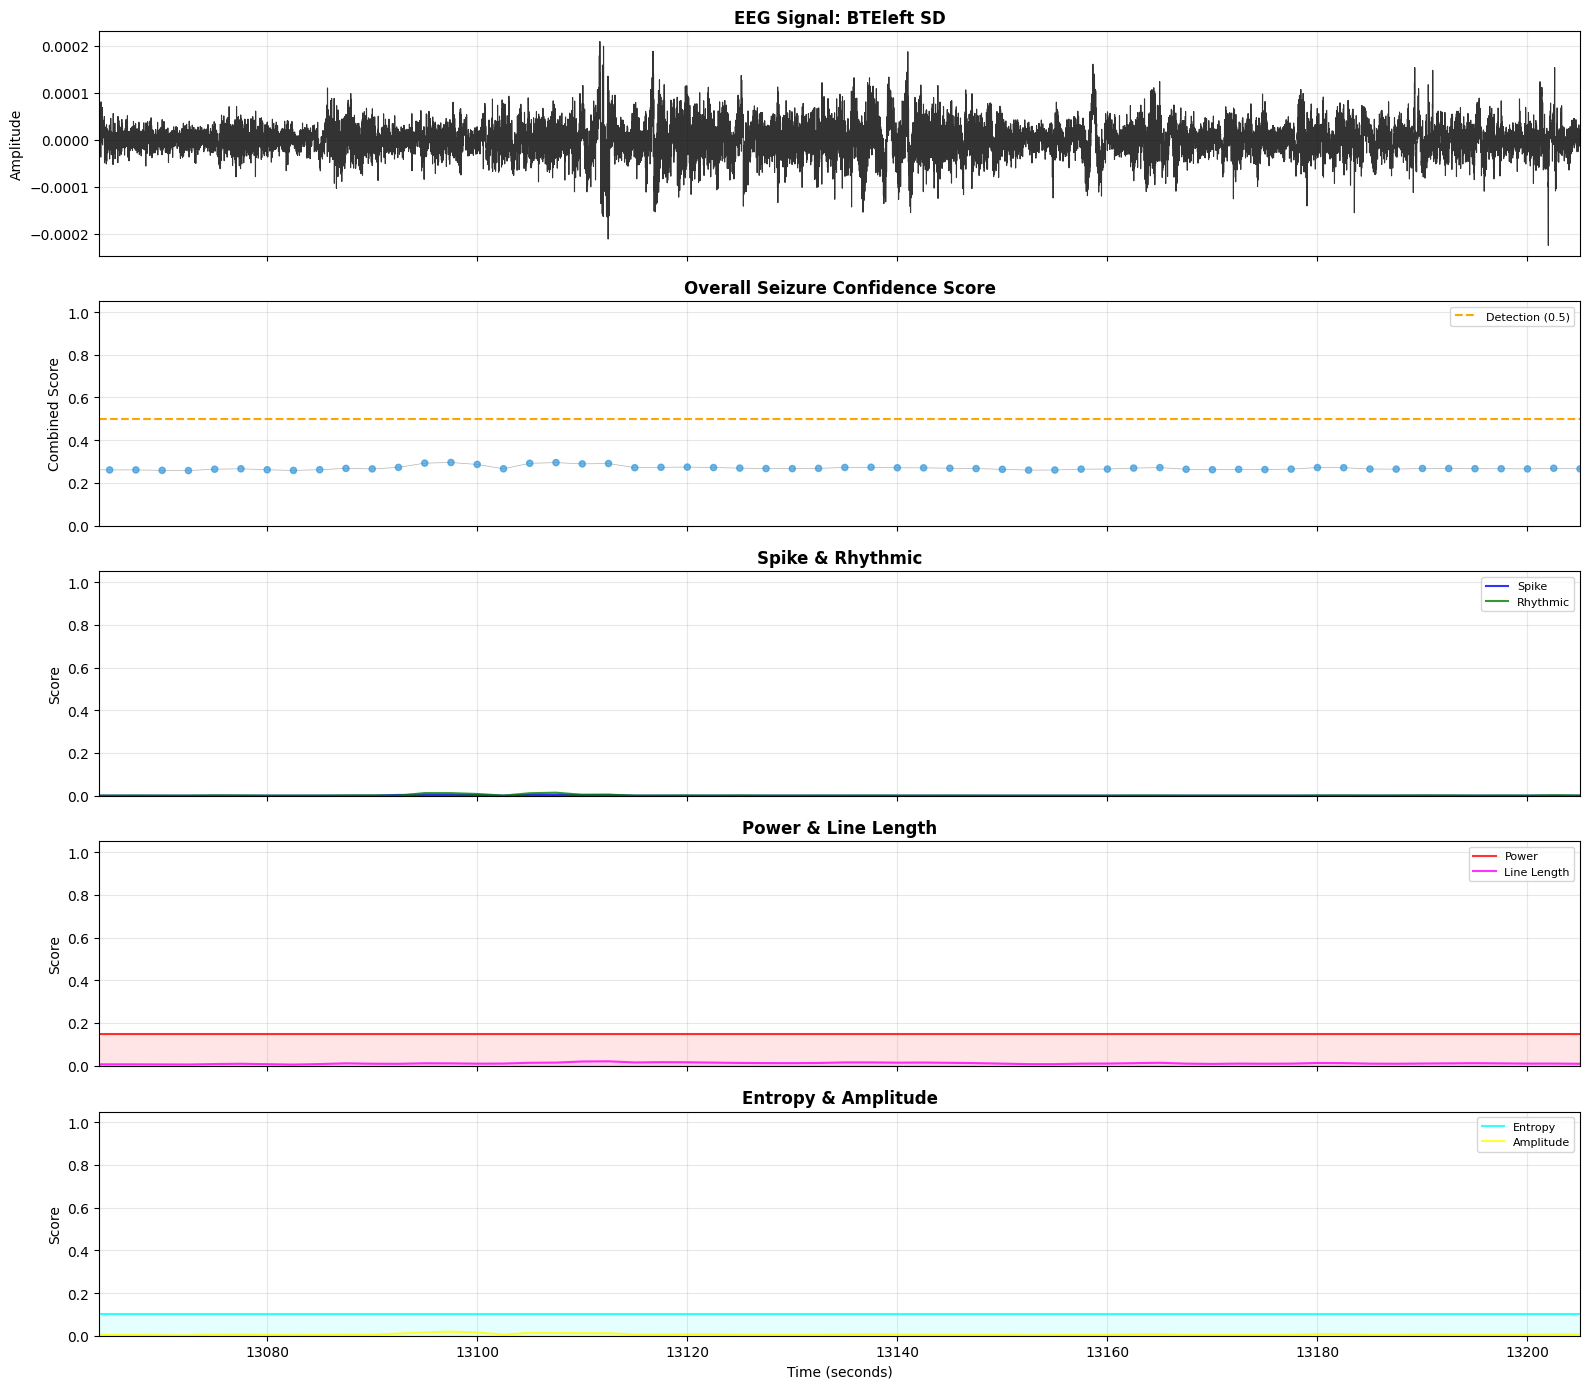


Visualizing Detection Results
  Time Range: 43528.0s - 43669.0s


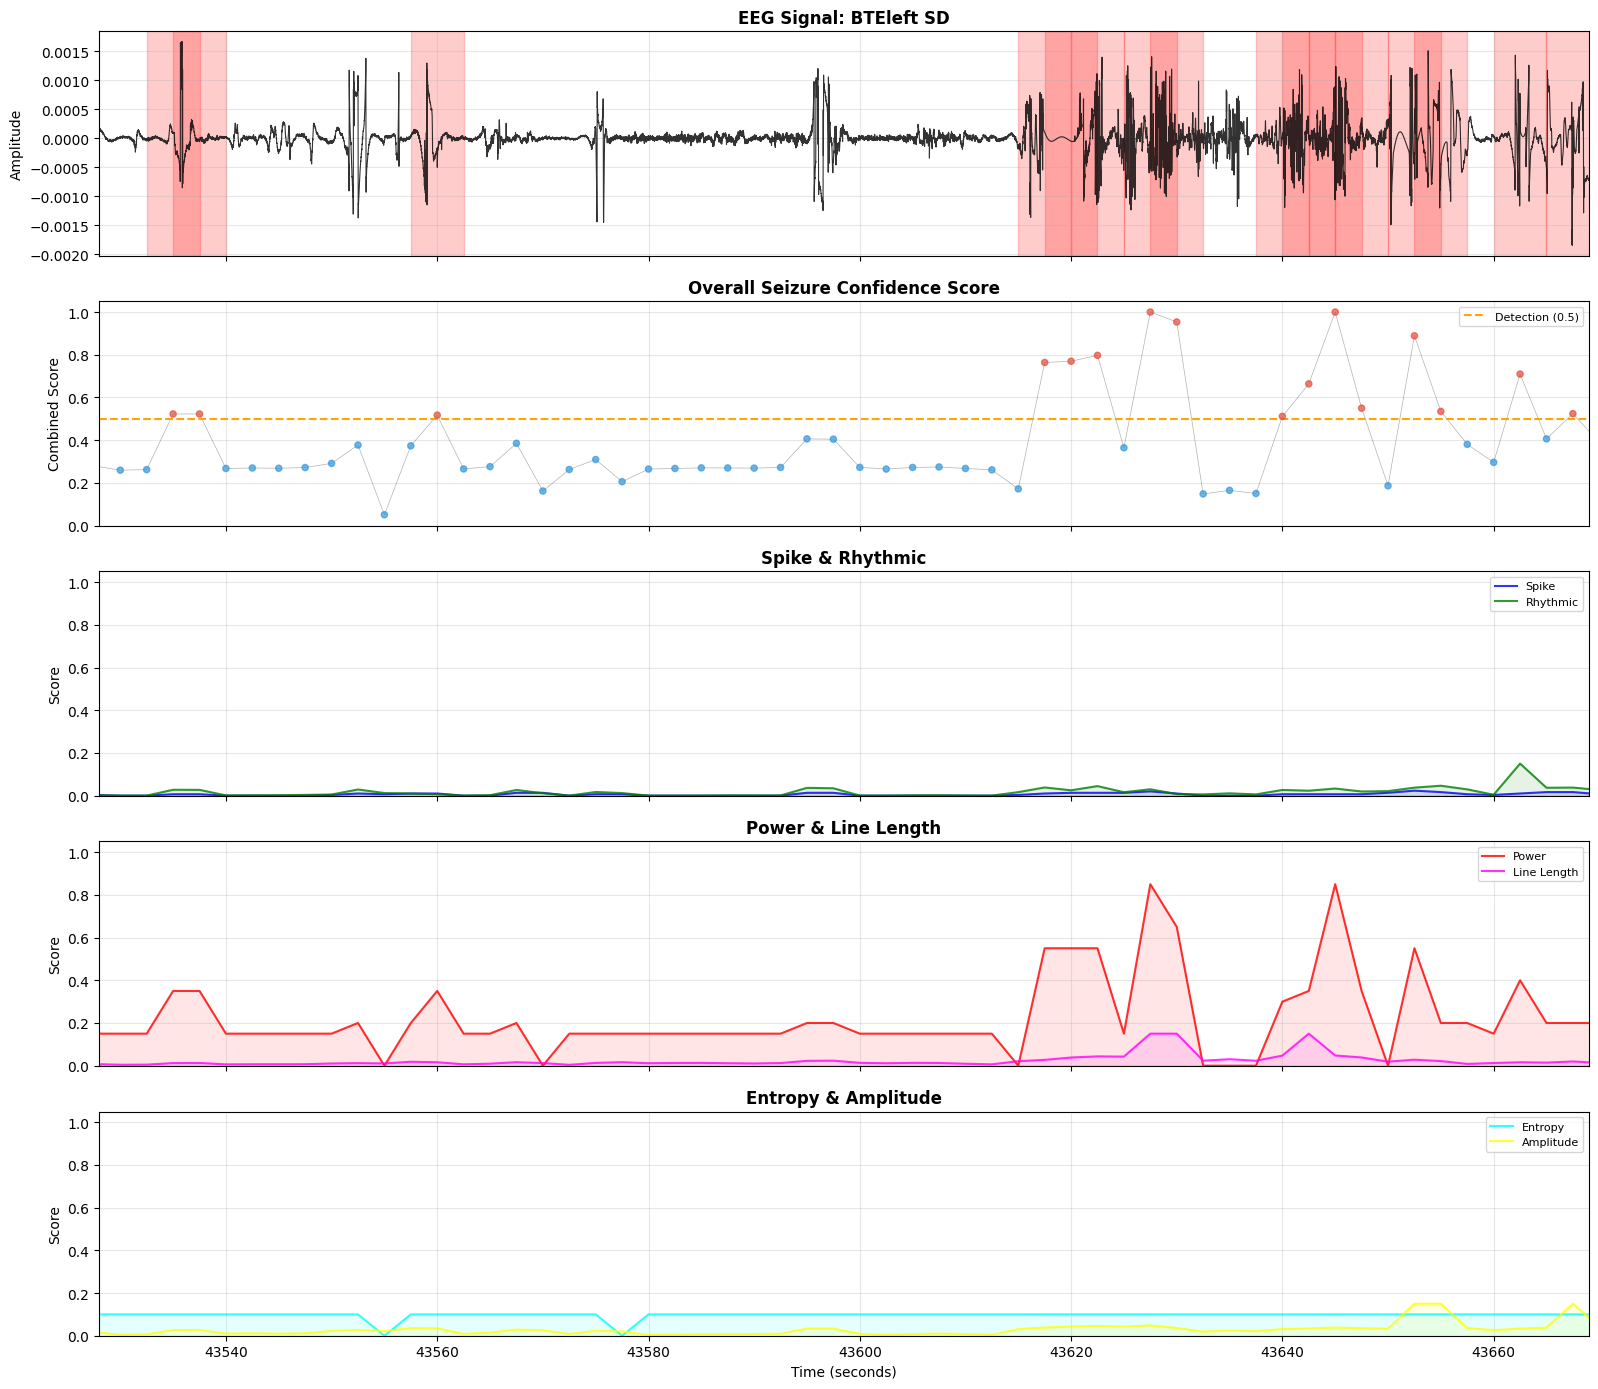

In [20]:
# Visualize detection results
if loader.annotations and len(loader.annotations.events) > 0:
    print("Generating visualizations around detected seizures...")
    seizures = loader.annotations.get_seizure_windows()
    for i in range(min(2, len(seizures))):
        seizure = seizures[i]
        time_range = (
            max(0, seizure['start_time'] - 60),
            min(loader.times[-1], seizure['end_time'] + 60)
        )
        visualize_detection(
            loader=loader,
            data_clean=data_clean,
            results_df=results_df,
            time_range=time_range
        )
else:
    print("No annotations - showing first 5 minutes...")
    visualize_detection(
        loader=loader,
        data_clean=data_clean,
        results_df=results_df
    )

## 7. Batch Analysis

Process all EDF files and generate aggregate performance metrics.


BATCH ANALYSIS - ALL FILES

BATCH VALIDATION: 3 FILES

[1/3] Validating: sub-013_ses-01_task-szMonitoring_run-01_eeg.edf
Loaded EDF: 2 channels, 69388.00s duration
Loaded annotations: 2 seizure events found

Seizure Annotations from sub-013_ses-01_task-szMonitoring_run-01_events.txt:

Seizure 1:
  Time: 13124.0s - 13145.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp

Seizure 2:
  Time: 43588.0s - 43609.0s
  Duration: 21.0s
  Type: sz_foc_ia_nm
  Lateralization: left
  Localization: temp
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete
Computing baseline from first 300.0 seconds...
  Baseline RMS: 0.000230
  Baseline STD: 0.000230
  Baseline computed successfully
  Sensitivity: 0.00%, Precision: 0.00%, Events: 0/2
[2/3] Validating: sub-053_ses-01_task-szMonitoring_run-03_eeg.edf
Loaded EDF: 2 channels, 33558.00s duration
Loaded annotations: 1 seizure events 

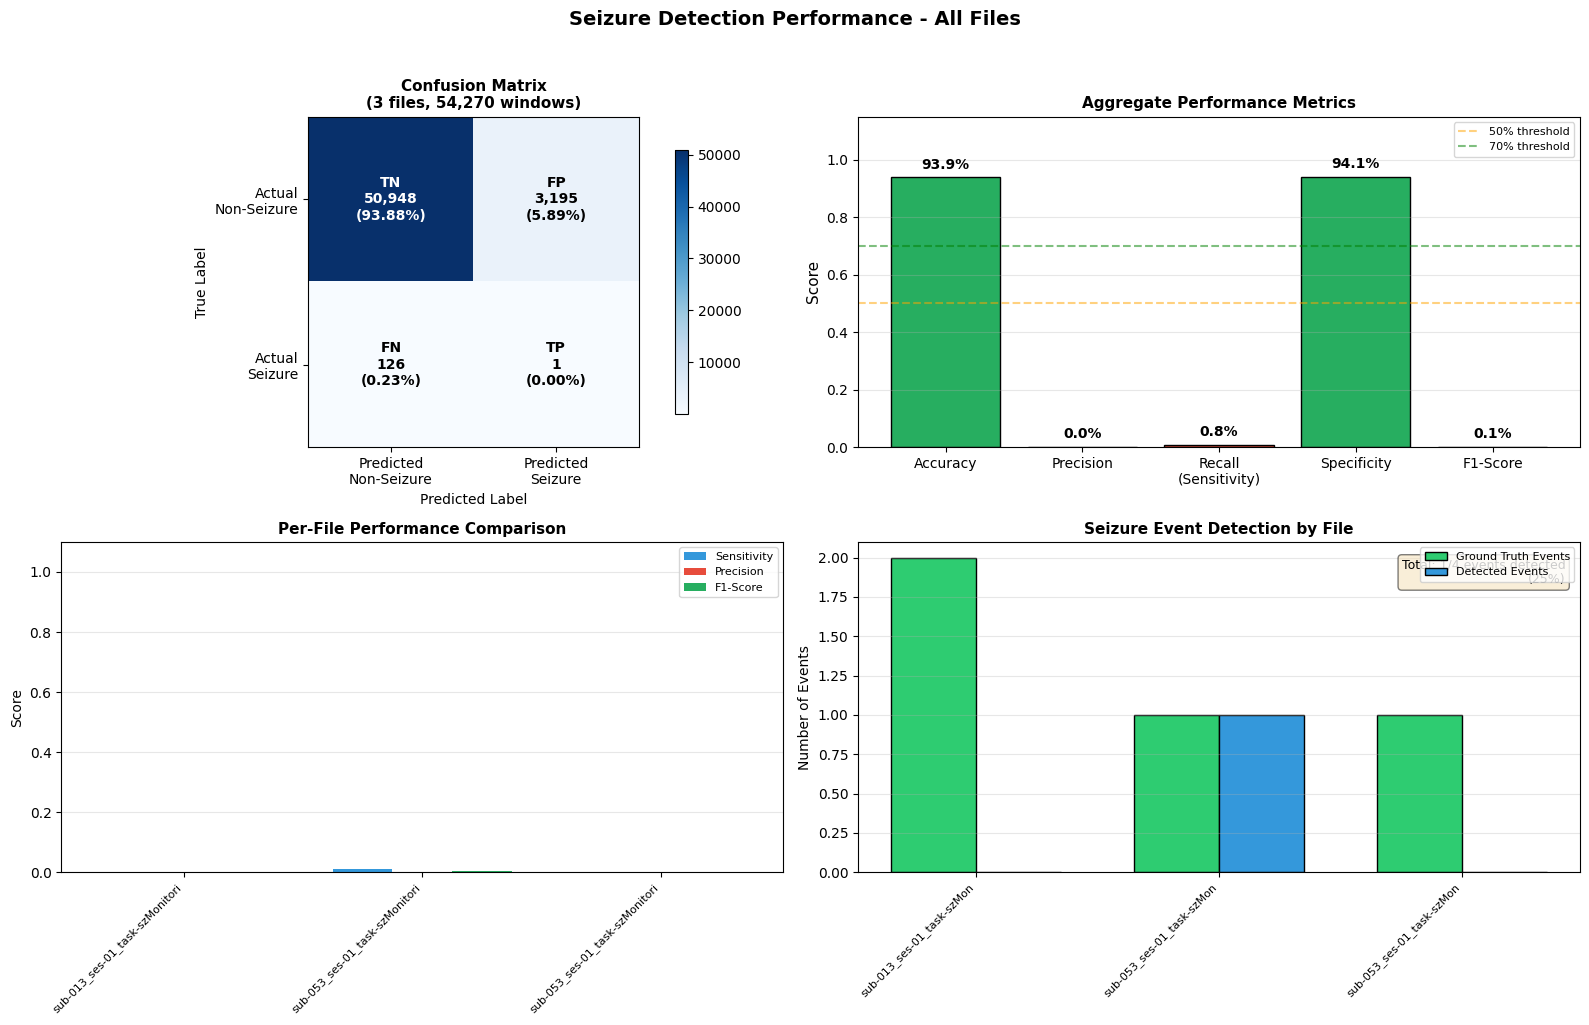


AGGREGATE PERFORMANCE METRICS

Files Analyzed: 3
Total Windows: 54,270

Confusion Matrix Summary:
  True Positives (TP):         1 - Correctly detected seizure windows
  True Negatives (TN):    50,948 - Correctly identified non-seizure windows
  False Positives (FP):    3,195 - Non-seizure windows incorrectly flagged
  False Negatives (FN):      126 - Missed seizure windows

Performance Metrics:
  Accuracy:    93.88%
  Precision:   0.03%
  Recall:      0.79%
  Specificity: 94.10%
  F1-Score:    0.06%

Event-Level Detection:
  Total Ground Truth Events: 4
  Events Detected: 1
  Event Detection Rate: 25.00%


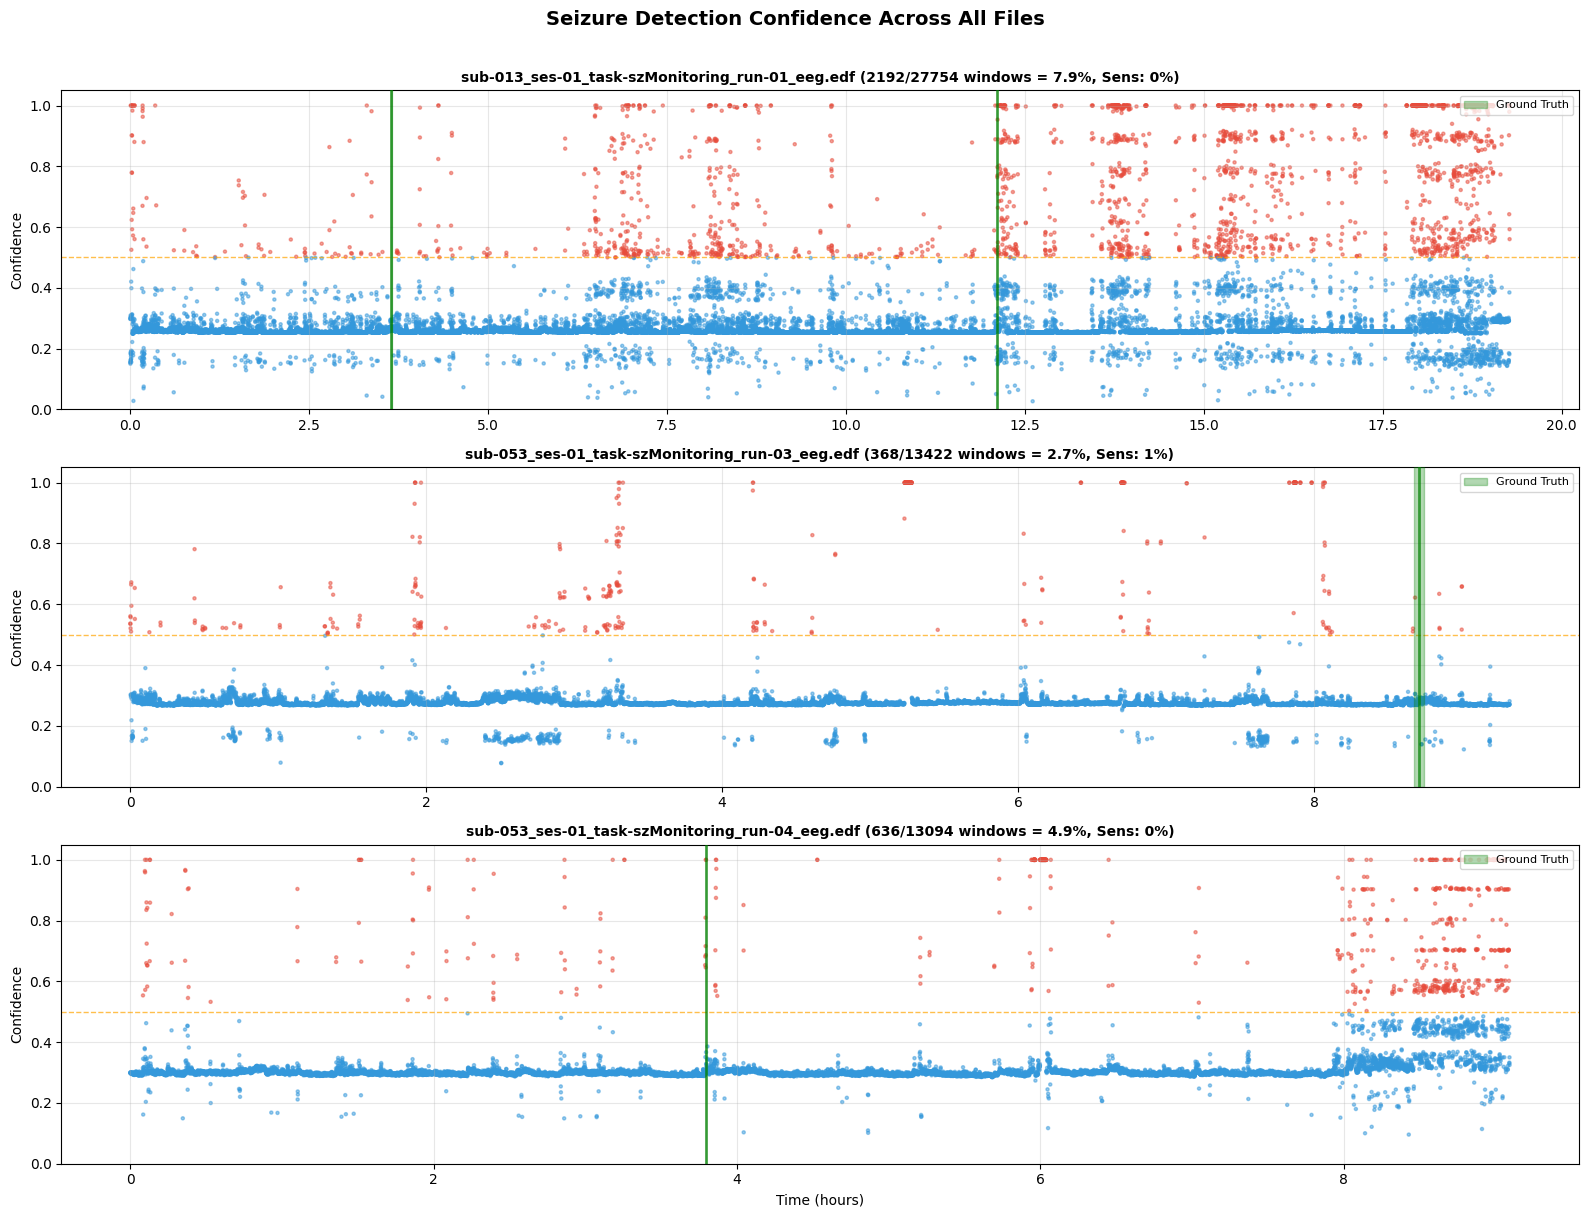

In [21]:
# Run batch validation on all files
print("\n" + "=" * 70)
print("BATCH ANALYSIS - ALL FILES")
print("=" * 70)

batch_validation = batch_validate_all_files(
    data_dir='data',
    window_size=5.0,
    detection_threshold=0.50
)

# Plot aggregate confusion matrix
if batch_validation:
    plot_batch_confusion_matrix(batch_validation, 
                                title="Seizure Detection Performance - All Files")
    
    # Plot detection overview with ground truth markers
    if 'all_results' in batch_validation:
        plot_batch_detection_overview(batch_validation)

### 7.1 Export Results

In [22]:
# Export results
print("\n" + "=" * 70)
print("EXPORTING RESULTS")
print("=" * 70)

export_results(results_df, report, output_prefix='seizure_detection_results')
print("\nResults exported to: results/")


EXPORTING RESULTS
Saved window results to results/seizure_detection_results_windows.csv
Saved seizure events to results/seizure_detection_results_events.csv
Saved report to results/seizure_detection_results_report.txt

Results exported to: results/


## 8. Summary


### Key Components

| Component               | Description                                  |
|-------------------------|----------------------------------------------|
| `SeizureDetector`       | Multi-method detection engine                |
| `SlidingWindowAnalyzer` | Processes recordings with configurable windows |
| `validate_detections()` | Computes confusion matrix and metrics        |
| `batch_validate_all_files()` | Aggregate validation across files       |

### Output Files

- `*_windows.csv` - Per-window detection scores
- `*_events.csv` - Detected seizure events with timestamps
- `*_report.txt` - Human-readable summary report

### Tuning Parameters

Key parameters in `CONFIG` that affect detection:

| Parameter           | Default | Description                              |
|---------------------|---------|------------------------------------------|
| `detection_threshold` | 0.5     | Confidence threshold for seizure detection |
| `window_size`       | 5.0s    | Analysis window duration                 |
| `overlap`           | 0.5     | Window overlap fraction                  |
